# **Trabajo Práctico N°2 - Aprendizaje Automático 1**
**Integrantes**:

Dito, Daniela

Flaibani, Marcela

López Crespo, Facundo

**Información meteorológica**: Maximiliano Yafusco

## Librerías

In [ ]:
import numpy as np
print(np.__version__)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
#from imblearn.over_sampling import RandomOverSampler, SMOTE
#from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, balanced_accuracy_score, classification_report, confusion_matrix)
from sklearn.metrics import make_scorer
#from scipy.stats import mode
import plotly.graph_objs as go
import plotly.express as px
import optuna
import jinja2
""" import pycaret
from pycaret.classification import * """
# import tensorflow as tf
import shap
import warnings
warnings.filterwarnings('ignore')



2.0.0


## 1. Análisis descriptivo 

### Observación del Dataset.

In [99]:
df = pd.read_csv('weatherAUS.csv')
df.shape

(145460, 23)

In [100]:
# Elección aleatoria de 10 ciudades
ciud = pd.Series(df['Location'].unique())
ciud_10 = ciud.sample(n=10,random_state=1)
ciud_10

27        Dartmoor
34       Nuriootpa
39    PerthAirport
48           Uluru
2            Cobar
3     CoffsHarbour
42         Walpole
29          Cairns
45    AliceSprings
30       GoldCoast
dtype: object

El dataset corresponde a los datos meteorológicos de Australia.

En el norte del país el clima es tropical, en el este y oeste el clima es mediterráneo y en el centro es desértico.

Por este motivo y dado a que la selección de las 10 ciudades es aleatoria, decidimos conservar la información de la variable Location, a través de sus coordenadas (Latitude, Longitude), lo que además generaliza el modelo a otras ubicaciones.

Dartmoor, Victoria: Latitud: -37.9167 Longitud: 141.2833

Nuriootpa, South Australia: Latitud: -34.4700 Longitud: 138.9960

Perth Airport, Western Australia: Latitud: -31.9403 Longitud: 115.9668

Uluru, Northern Territory: Latitud: -25.3444 Longitud: 131.0369

Cobar, New South Wales: Latitud: -31.4983 Longitud: 145.8389

Coffs Harbour, New South Wales: Latitud: -30.2963 Longitud: 153.1157

Walpole, Western Australia: Latitud: -34.9780 Longitud: 116.7330

Cairns, Queensland: Latitud: -16.9203 Longitud: 145.7700

Alice Springs, Northern Territory: Latitud: -23.6980 Longitud: 133.8807

Gold Coast, Queensland: Latitud: -28.0167 Longitud: 153.4000

In [101]:
# Filtro del df según ciudades seleccionadas y luego descarto la columna ciudad 
df_weather = df[df['Location'].isin(ciud_10)]

In [102]:
ciudades_coords = {
    'Dartmoor': {'Latitud': -37.9167, 'Longitud': 141.2833},
    'Nuriootpa': {'Latitud': -34.4700, 'Longitud': 138.9960},
    'PerthAirport': {'Latitud': -31.9403, 'Longitud': 115.9668},
    'Uluru': {'Latitud': -25.3444, 'Longitud': 131.0369},
    'Cobar': {'Latitud': -31.4983, 'Longitud': 145.8389},
    'CoffsHarbour': {'Latitud': -30.2963, 'Longitud': 153.1157},
    'Walpole': {'Latitud': -34.9780, 'Longitud': 116.7330},
    'Cairns': {'Latitud': -16.9203, 'Longitud': 145.7700},
    'AliceSprings': {'Latitud': -23.6980, 'Longitud': 133.8807},
    'GoldCoast': {'Latitud': -28.0167, 'Longitud': 153.4000}
}

df_weather['Latitude'] = df_weather['Location'].map(lambda loc: ciudades_coords[loc]['Latitud'])
df_weather['Longitude'] = df_weather['Location'].map(lambda loc: ciudades_coords[loc]['Longitud'])
df_weather = df_weather.drop('Location',axis=1)

In [103]:
df_weather.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Latitude', 'Longitude'],
      dtype='object')

El dataset a analizar se compone de observaciones diarias de las siguientes variables meteorológicas:
* **Temperatura**: [MinTemp, MaxTemp, Temp9am, Temp3pm]. Variables cuantitativas continuas. 

* **Lluvia**: 

    [Rainfall]. Variable cuantitavia continua.

    [RainToday, RainTomorrow]. Variable cualitativa nominal.
* **Evaporización**: [Evaporation]. Variable cuantitavia .

* **Luminosidad**: [Sunshine]. Variable cuantitativa. 
* **Viento**: 

    [WindSpeed9am, WindSpeed3pm, WindGustSpeed]. Variables cuantitativas continuas.

    [WindGustDir, WindDir9am, WindDir3pm]. Variables cualitativas nominales
* **Humedad**: [Humidity9am, Humidity3pm]. Variables cuantitativas continuas. 

* **Presión**: [Pressure9am, Pressure3pm]. Variables cuantitativas continuas.  
* **Nubosidad**: [Cloud9am, Cloud3pm]. Variables cuantitativas continuas.  


In [104]:
# Elimino las observaciones cuya variable target tiene valor nulo
df_weather = df_weather.dropna(subset=['RainTomorrow'])

In [105]:
# En relación al tiempo se utilizan las features Date(cuantitativa) y Month(cualitativa)
df_weather['Date']=pd.to_datetime(df_weather['Date'],format='mixed')
# df_weather['Date'] = pd.to_datetime(df_weather['Date'], errors='coerce')
df_weather['Month'] = df_weather['Date'].dt.month
meses = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']
month_dict = {}
for i,mes in enumerate(meses):
    month_dict[i+1] = mes
df_weather['Month'] = df_weather['Month'].map(month_dict)


In [106]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28234 entries, 6049 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           28234 non-null  datetime64[ns]
 1   MinTemp        28193 non-null  float64       
 2   MaxTemp        28211 non-null  float64       
 3   Rainfall       28049 non-null  float64       
 4   Evaporation    18330 non-null  float64       
 5   Sunshine       15473 non-null  float64       
 6   WindGustDir    27545 non-null  object        
 7   WindGustSpeed  27591 non-null  float64       
 8   WindDir9am     26591 non-null  object        
 9   WindDir3pm     27770 non-null  object        
 10  WindSpeed9am   27878 non-null  float64       
 11  WindSpeed3pm   27886 non-null  float64       
 12  Humidity9am    27887 non-null  float64       
 13  Humidity3pm    27881 non-null  float64       
 14  Pressure9am    27926 non-null  float64       
 15  Pressure3pm    27926

In [107]:
df_weather.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Latitude,Longitude,Month
6049,2009-01-01,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,1004.4,2.0,5.0,26.6,33.4,No,No,-31.4983,145.8389,ene
6050,2009-01-02,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,1012.1,1.0,1.0,20.3,27.0,No,No,-31.4983,145.8389,ene
6051,2009-01-03,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,...,1011.6,NaN,1.0,NaN,32.7,No,No,-31.4983,145.8389,ene
6052,2009-01-04,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,1009.2,1.0,6.0,28.7,34.9,No,No,-31.4983,145.8389,ene
6053,2009-01-05,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,1009.1,1.0,5.0,29.1,35.6,No,No,-31.4983,145.8389,ene


### División del DataSet: Train - Test

In [108]:
# División del DF entre train y test VER STRATIFY
X = df_weather.drop(columns='RainTomorrow')
y = df_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22587, 24), (5647, 24), (22587,), (5647,))

In [109]:
#Armo los data frame de entrenamiento y de testeo
df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([y_test,y_test],axis=1)

In [110]:
# Filtro aquellos registros de entrenamiento que no tienen más de 3 features nulas 
# es lo que permite el límite del 5% para eliminar registros del conjunto de entrenamiento
idxs_registros_aceptables = df_train.dropna(thresh=18).index
X_train = X_train.loc[idxs_registros_aceptables]
y_train = y_train.loc[idxs_registros_aceptables]
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [111]:
X_train.shape

(22253, 24)

In [112]:
# Solamente se describen variables cuantitativas
round(X_train.describe(),1)

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Latitude,Longitude
count,22253,22228.0,22236.0,22159.0,14656.0,12411.0,22032.0,22223.0,22223.0,22014.0,22009.0,22208.0,22208.0,13224.0,12828.0,22246.0,22241.0,22253.0,22253.0
mean,2013-05-01 00:43:13.591875072,13.6,25.0,2.6,5.8,8.0,40.1,15.3,19.5,63.6,49.4,1017.5,1014.9,3.9,4.0,19.1,23.5,-29.7,137.9
min,2008-12-01 00:00:00,-5.2,7.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,982.0,985.1,0.0,0.0,-0.3,5.3,-37.9,116.0
25%,2011-02-13 00:00:00,8.8,19.8,0.0,2.8,5.3,31.0,9.0,13.0,50.0,30.0,1013.0,1010.3,1.0,1.0,13.9,18.4,-34.5,131.0
50%,2013-06-26 00:00:00,13.4,24.9,0.0,5.0,9.0,39.0,15.0,19.0,65.0,52.0,1017.4,1014.8,4.0,4.0,19.0,23.2,-31.5,141.3
75%,2015-07-04 00:00:00,18.8,29.9,0.8,8.0,10.9,46.0,20.0,24.0,80.0,66.0,1021.9,1019.3,7.0,7.0,24.2,28.1,-25.3,145.8
max,2017-06-25 00:00:00,31.0,46.6,371.0,86.2,14.3,113.0,72.0,61.0,100.0,100.0,1040.4,1037.7,8.0,8.0,39.4,45.2,-16.9,153.4
std,NaN,6.4,6.9,10.3,4.3,3.7,11.9,8.2,8.2,22.1,23.1,6.6,6.6,2.9,2.8,6.6,6.8,6.0,12.8


In [113]:
# Obtengo el porcentaje de valores faltantes por feature
round(X_train.isna().sum().sort_values(ascending=False) / len(X_train) * 100, 0) 

Sunshine         44.0
Cloud3pm         42.0
Cloud9am         41.0
Evaporation      34.0
WindDir9am        5.0
Humidity3pm       1.0
Humidity9am       1.0
WindGustDir       1.0
WindGustSpeed     1.0
WindDir3pm        0.0
RainToday         0.0
Rainfall          0.0
Pressure3pm       0.0
Pressure9am       0.0
WindSpeed9am      0.0
WindSpeed3pm      0.0
MinTemp           0.0
MaxTemp           0.0
Temp3pm           0.0
Temp9am           0.0
Date              0.0
Latitude          0.0
Longitude         0.0
Month             0.0
dtype: float64

In [114]:
# Interesa distinguir las features cuantitativas de aquellas features cualitativas
features_cuanti = list(X_train.describe().columns)
features_cuali = [feature for feature in X_train.columns if feature not in features_cuanti]
print(f'Features cuantitativas:\n')
[print(feature_cuanti) for feature_cuanti in features_cuanti]
print(f'Features cualitativas:\n')
[print(feature_cuali) for feature_cuali in features_cuali]
# Elimino feature date de cuanti para que después no traiga problemas
features_cuanti.remove('Date')

Features cuantitativas:

Date
MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
Latitude
Longitude
Features cualitativas:

WindGustDir
WindDir9am
WindDir3pm
RainToday
Month


In [115]:
# Las variables cualitativas que presenta el df son de tipo nominal, pues no se pueden ordenar jerárquicamente
[print(f"{feature_cuali}:\n{X_train[feature_cuali].unique()}") for feature_cuali in features_cuali]
    

WindGustDir:
['ESE' 'WSW' 'SSW' 'ENE' 'E' 'SE' 'S' 'WNW' 'W' 'SW' 'N' 'NW' 'SSE' 'NE'
 'NNW' 'NNE' nan]
WindDir9am:
['E' 'S' 'N' 'ESE' 'SE' 'NW' 'NE' nan 'SSE' 'WSW' 'WNW' 'SW' 'SSW' 'NNE'
 'ENE' 'NNW' 'W']
WindDir3pm:
['ESE' 'WSW' 'WNW' 'S' 'SW' 'ENE' 'NE' 'E' 'N' 'SE' 'NW' 'W' 'NNE' 'SSW'
 'NNW' 'SSE' nan]
RainToday:
['No' 'Yes' nan]
Month:
['jun' 'oct' 'feb' 'sep' 'ene' 'mar' 'dic' 'may' 'ago' 'jul' 'nov' 'abr']


[None, None, None, None, None]

In [116]:
# Obtengo el porcentaje de valores atípicos por feature cuantitativa
serie_porcentaje_atipicos = pd.Series()
for feature in features_cuanti:
    serie = X_train[feature]
    q1 , q3 = serie.quantile(q=[0.25,0.75])
    r_i = q3 - q1
    lim_inf = q1 - 1.5 * r_i
    lim_sup = q3 + 1.5 * r_i
    # En caso que trate atípicos puede ser conveniente la línea de abajo
    #feature_idx_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].index
    n_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].count()
    n_no_nan = serie.count()
    porcen_atipicos = round(n_atipicos / n_no_nan * 100,2)  
    serie_porcentaje_atipicos[feature] = porcen_atipicos
serie_porcentaje_atipicos.sort_values(ascending=False) 

Rainfall         18.18
WindGustSpeed     2.64
Evaporation       1.88
WindSpeed3pm      1.52
WindSpeed9am      1.12
Pressure9am       0.79
Pressure3pm       0.59
Humidity9am       0.10
Temp3pm           0.05
MaxTemp           0.01
MinTemp           0.00
Sunshine          0.00
Humidity3pm       0.00
Cloud9am          0.00
Cloud3pm          0.00
Temp9am           0.00
Latitude          0.00
Longitude         0.00
dtype: float64

### Visualización de datos: boxplots, histogramas y scatter plots

In [117]:
def visualizar_features_cuanti_sin_lluvia(tipo_grafico: str) -> None:
    # A la feature lluvia Rainfall se le aplicará un análisis particular
    features_cuanti_sin_lluvia = features_cuanti.copy()
    features_cuanti_sin_lluvia.remove('Rainfall')
    n_features_cuanti_sin_lluvia = len(features_cuanti_sin_lluvia)
    n_col = 3
    n_row = n_features_cuanti_sin_lluvia // n_col if n_features_cuanti_sin_lluvia % n_col == 0 else n_features_cuanti_sin_lluvia // n_col + 1
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col * 5, 5 * n_row))
    titulo = 'Boxplots de las variables predictoras cuantitativas según valor de la variable target' if tipo_grafico == 'boxplots' else "Histogramas de variables cuantitativas"
    fig.suptitle(titulo, fontsize=16)
    fig.subplots_adjust(hspace=0.2)

    # Definir la paleta de colores para 'Yes' y 'No'
    palette = {'Yes': 'darkorange', 'No': 'lightblue'}

    for i, feature in enumerate(features_cuanti_sin_lluvia):
        # Posición de cada gráfico 
        row = i // n_col
        col = i % n_col
        
        if tipo_grafico == 'boxplots':
            sns.boxplot(data=X_train, x=y_train, y=feature, ax=axes[row, col], palette=palette)
        else:
            sns.histplot(df_train[feature],ax=axes[row, col])  
                # Eliminar subplots vacíos si es necesario
    if n_features_cuanti_sin_lluvia % n_col != 0:
        for i in range(n_features_cuanti_sin_lluvia % n_col, n_col):
            fig.delaxes(axes[n_row - 1, i])

    plt.show()


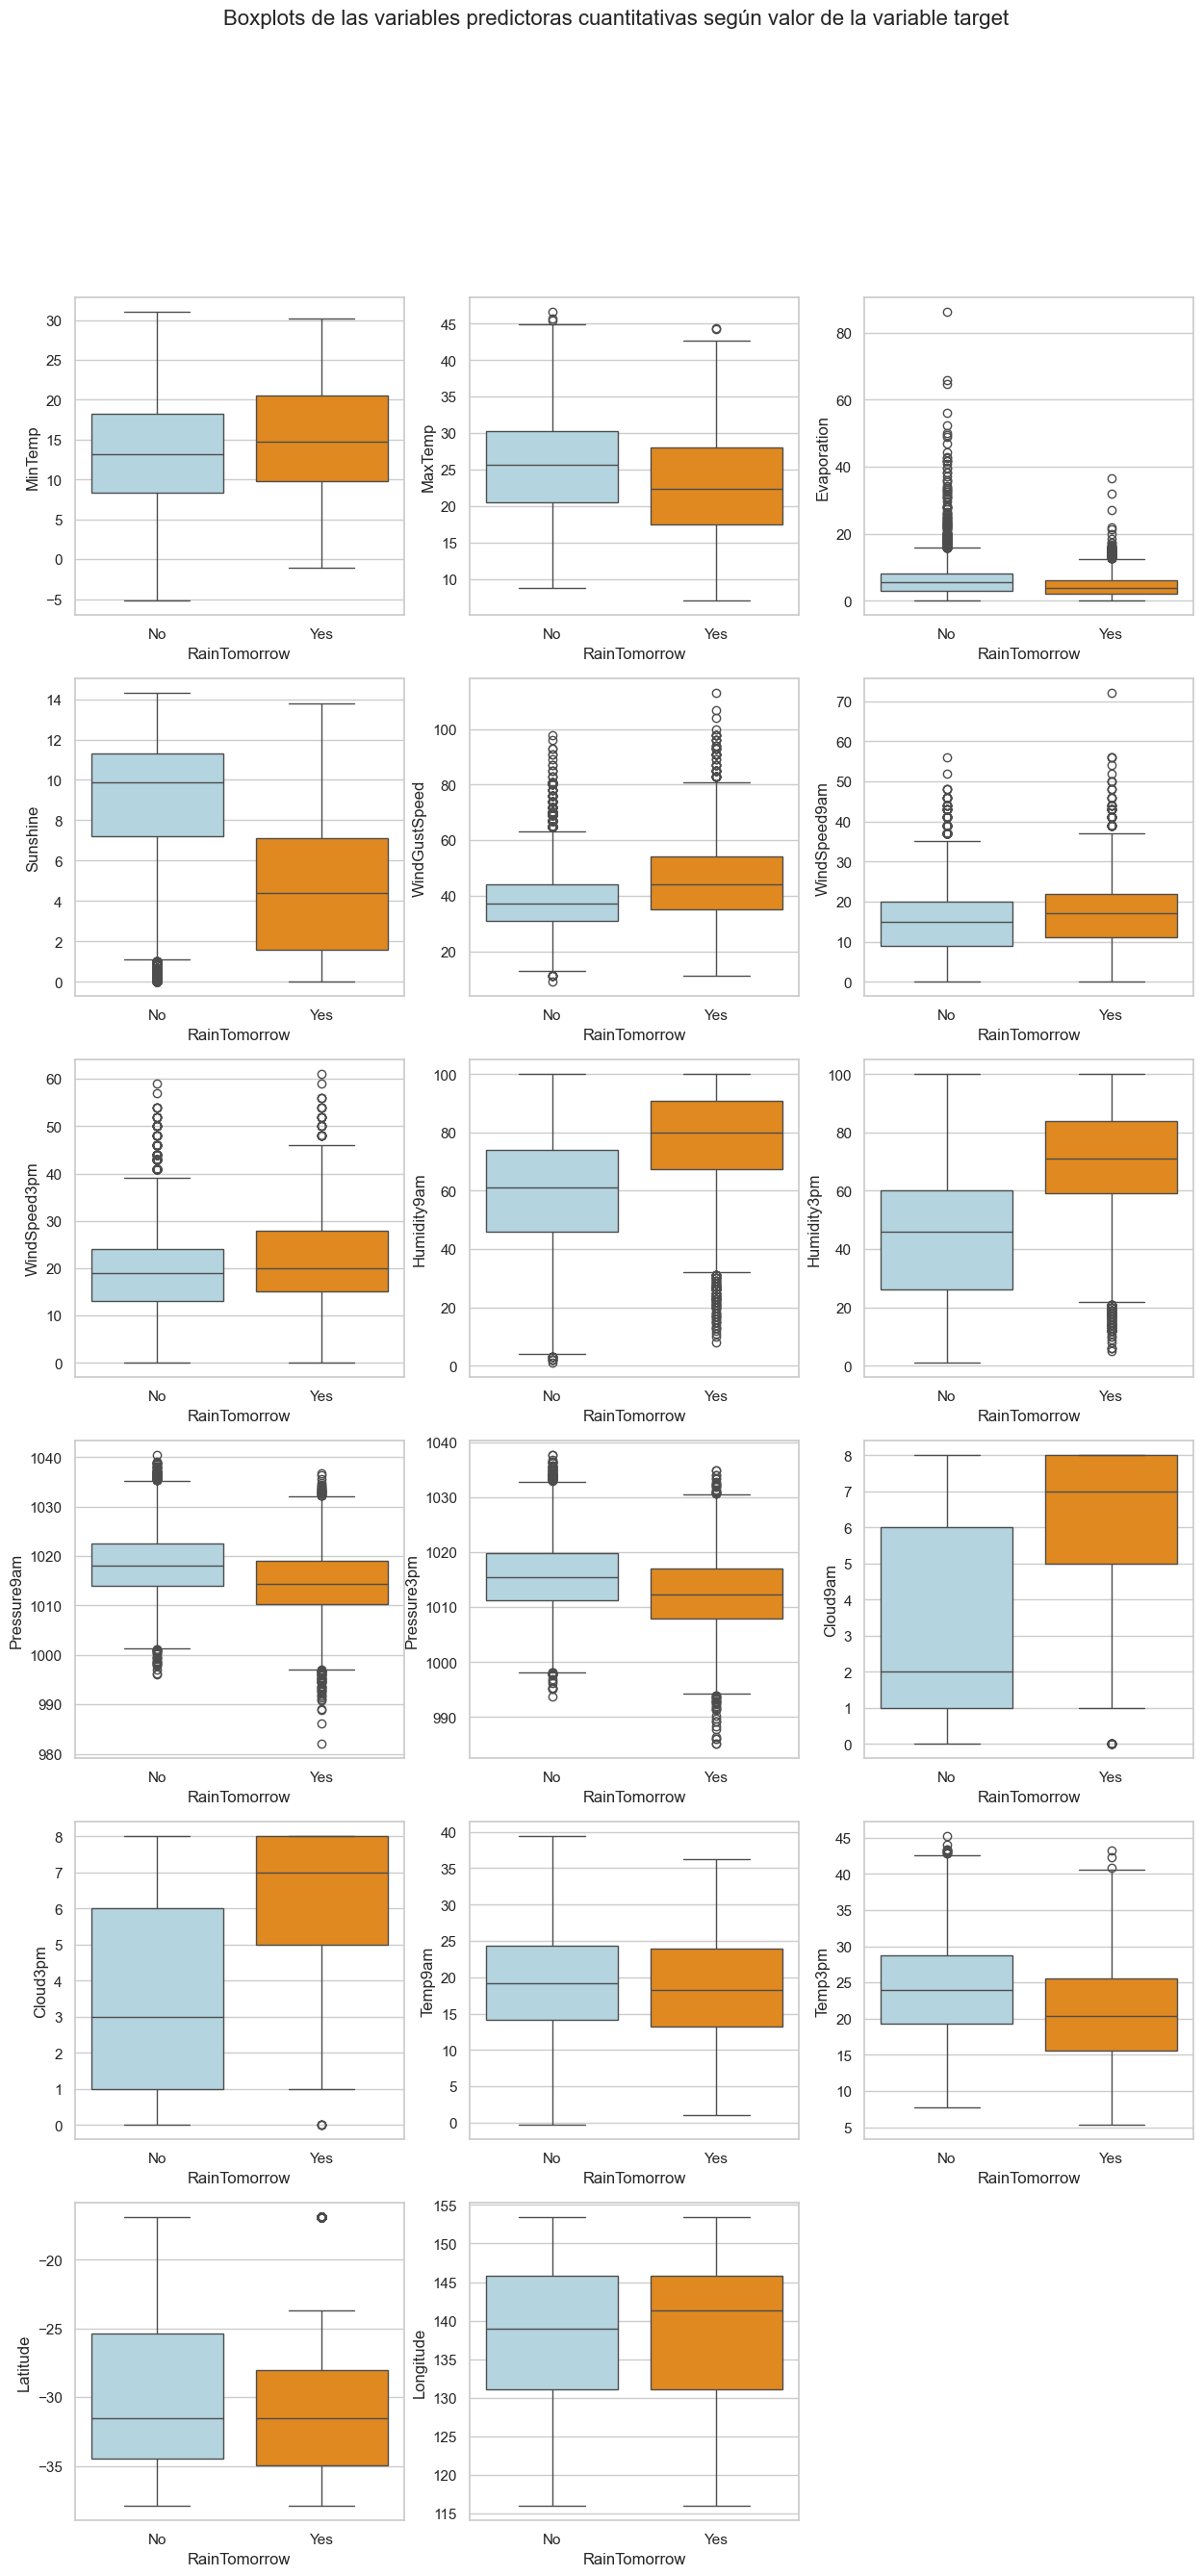

In [118]:
# A la función puede recibir el string boxplots, caso contrario grafica histogramas
visualizar_features_cuanti_sin_lluvia('boxplots')

Se observa que cuando la humedad es mayor al 60% es altamente probable que llueva.

Cuando no llovió, solamente en el 25% de los casos la humedad presentó un valor mayor.

Cuando sí llovió, en el 75% de los casos, el valor superó dicha referencia. 

Esto se informa a modo de justificación acerca de la elección de esta variable para construir el modelo ingenuo solicitado en el punto 3 del TP.

ADVERTENCIA: Se observa que las features vinculadas con la nubosidad (Sunshine | Cloud9am | Cloud3pm)
son muy importante para explicar la variable target, sin embargo, para un alto porcentaje de las observaciones no se dispone de los datos relativos a la nubosidad.

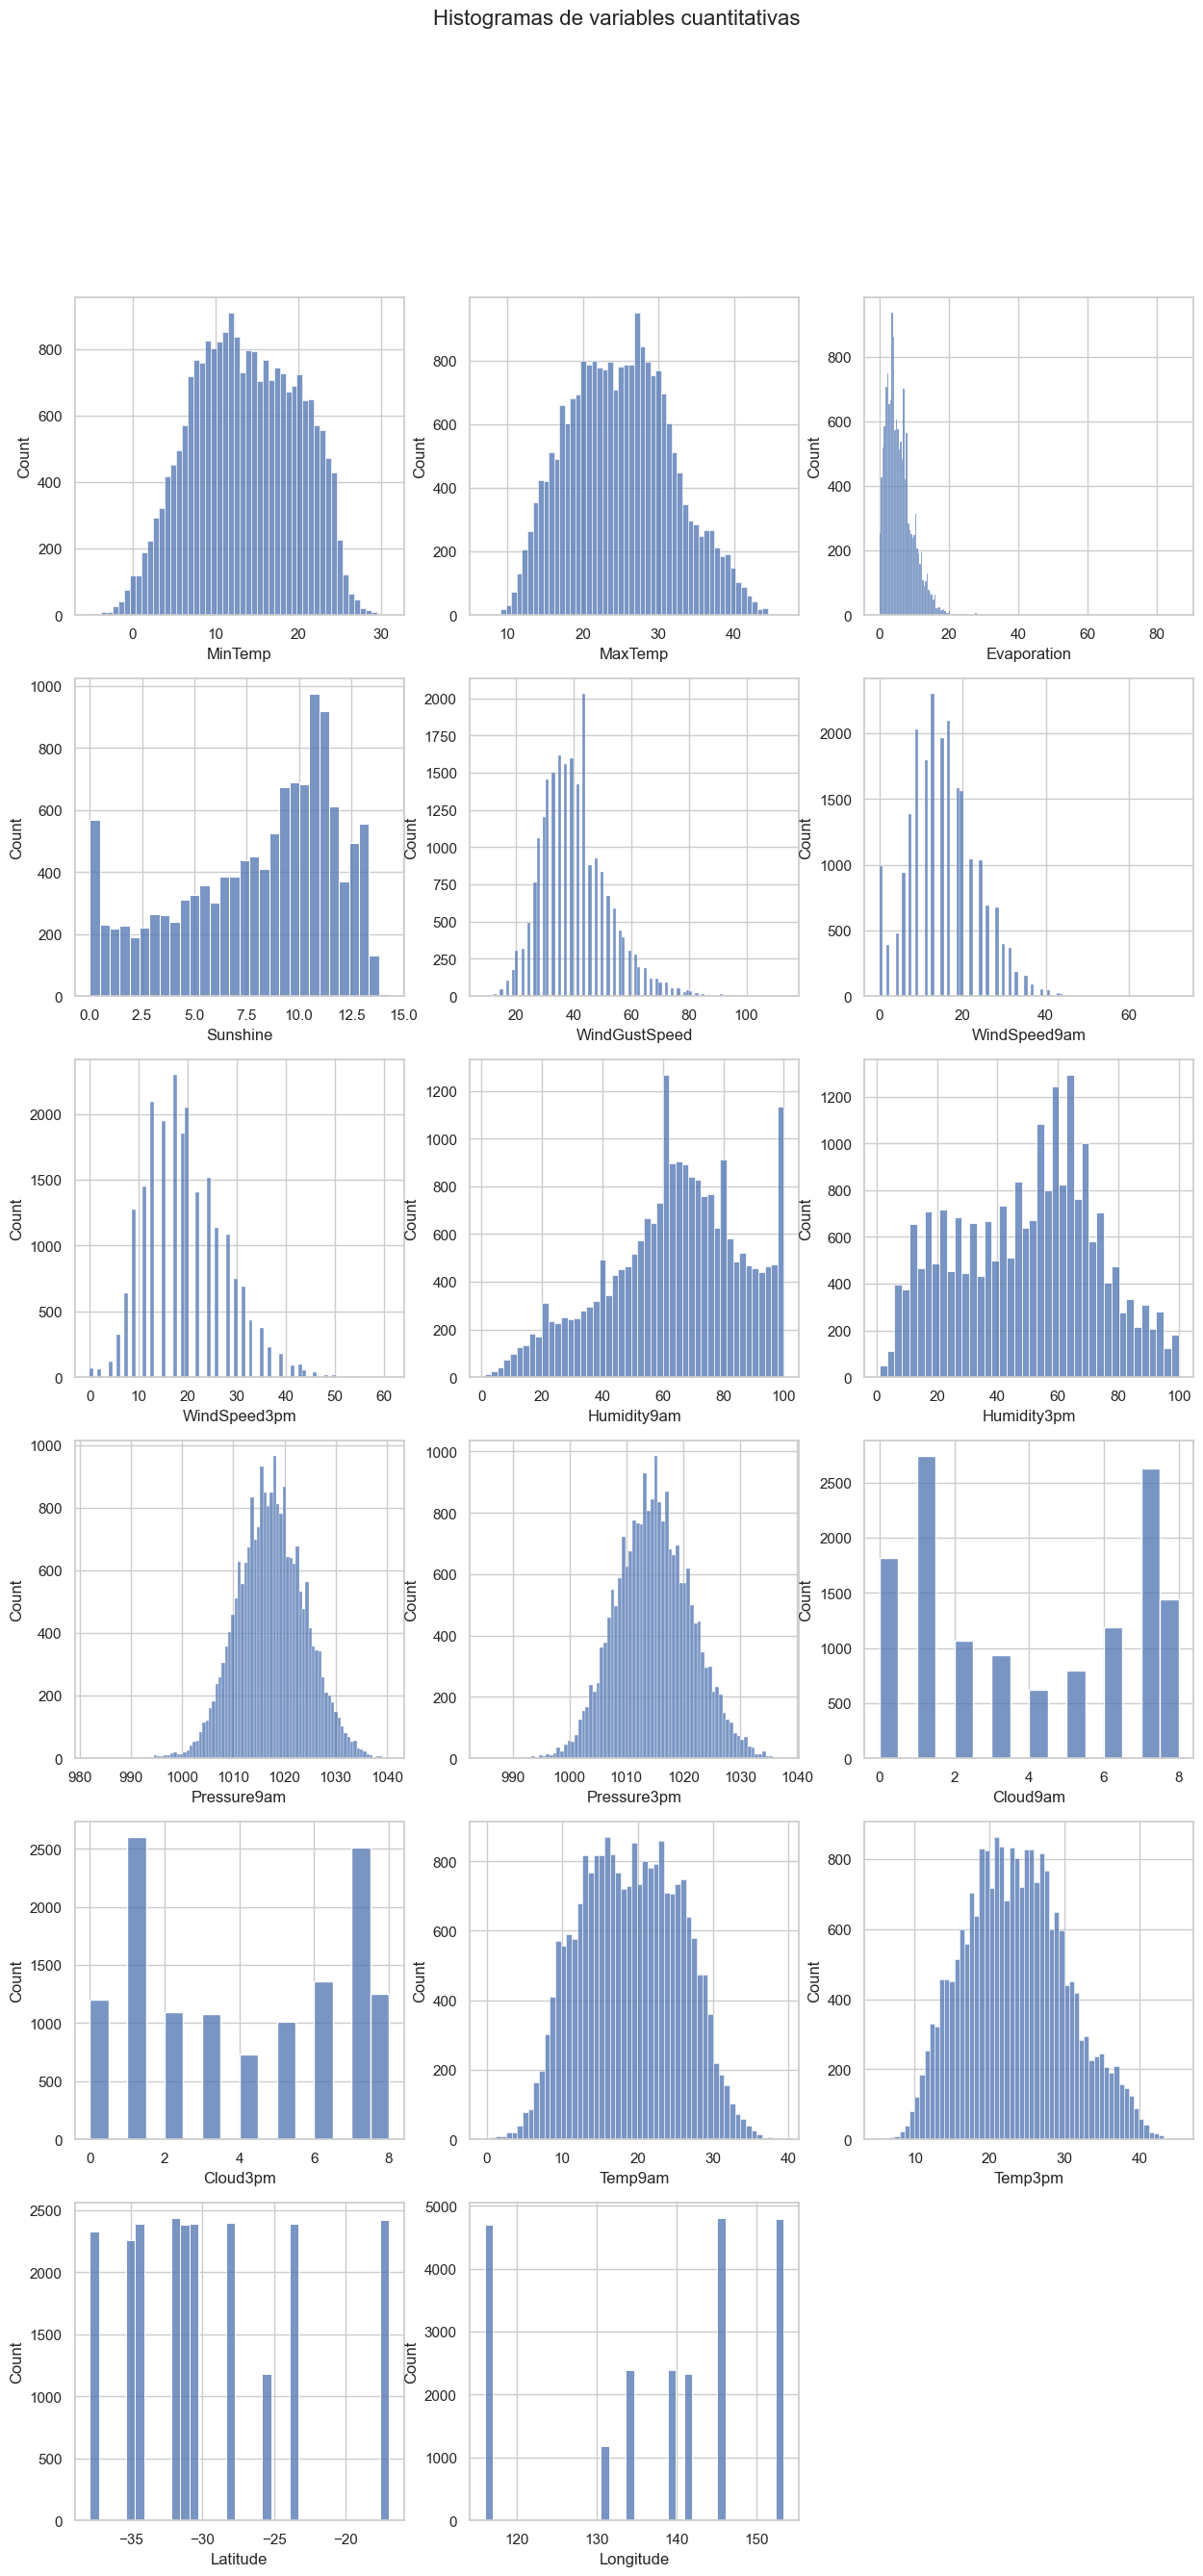

In [119]:
visualizar_features_cuanti_sin_lluvia('histogramas')

El análisis de los histogramas serán tenidos en cuenta para la imputación de faltantes.
Se observa que las siguientes features son 
* simétricas:
Temperatura (en todas sus versiones)
* asimétricas:
Evaporación | Viento (en todas sus versiones) | Humedad (en todas sus versiones) | Presión (en todas sus versiones)
* bimodales:
Nubosidad (en todas sus versiones) | Radiación Solar

Se observa que existe cierto grado de correlación positiva entre esas variables cualitativas

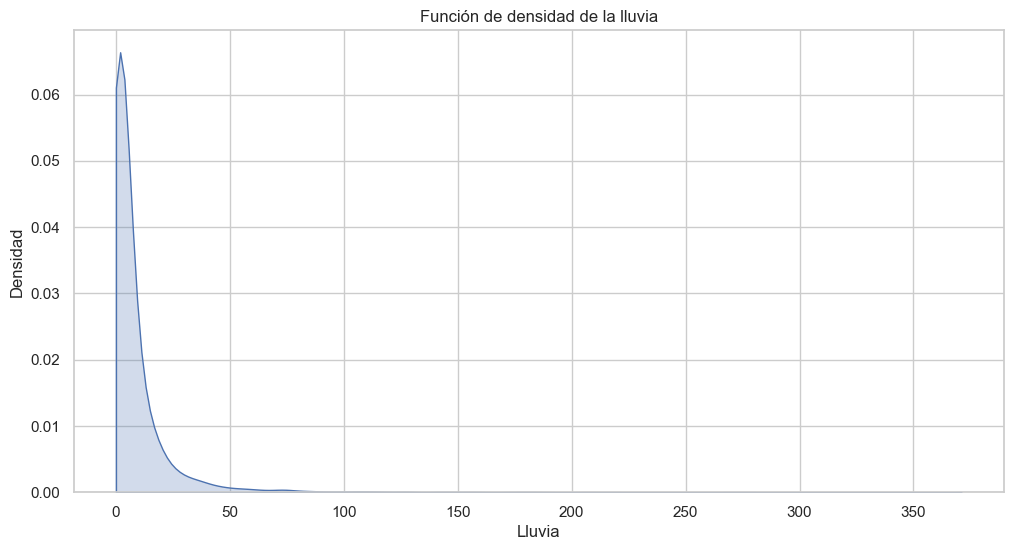

In [120]:
# Se grafica la función de densidad de la feature Rainfall para aquellos días que llovió
s_lluvia = X_train[X_train['Rainfall']>0]['Rainfall']
bandwidth = 1.5
plt.figure(figsize=(12, 6))
sns.kdeplot(data=s_lluvia, fill=True, bw_adjust=bandwidth,cut=0)
plt.title('Función de densidad de la lluvia')
plt.xlabel('Lluvia')
plt.ylabel('Densidad')
current_values = plt.gca().get_xticks()
plt.show()

In [121]:
# Se construye esta tabla para evidenciar la presencia de valores fuertemente atípicos para la variable llvua
rangos_lluvia = pd.cut(s_lluvia,bins=range(0,401,50), right=True)
df_frec_lluvia = rangos_lluvia.value_counts().sort_index().reset_index()
df_frec_lluvia.rename(columns={'Rainfall':'Rainfall','count':'Frecuencia_absoluta'},inplace=True)
df_frec_lluvia.set_index('Rainfall',inplace=True)
df_frec_lluvia['Frecuencia_relativa'] = round(df_frec_lluvia['Frecuencia_absoluta'] / df_frec_lluvia['Frecuencia_absoluta'].sum(),4)
df_frec_lluvia['Frecuencia_absoluta_acumulada'] = df_frec_lluvia['Frecuencia_absoluta'].cumsum()
df_frec_lluvia['Frecuencia_relativa_acumulada'] = df_frec_lluvia['Frecuencia_relativa'].cumsum()
df_frec_lluvia

,Frecuencia_absoluta,Frecuencia_relativa,Frecuencia_absoluta_acumulada,Frecuencia_relativa_acumulada
Rainfall,,,,
"(0, 50]",7467,0.9780,7467,0.9780
"(50, 100]",119,0.0156,7586,0.9936
"(100, 150]",32,0.0042,7618,0.9978
"(150, 200]",11,0.0014,7629,0.9992
"(200, 250]",3,0.0004,7632,0.9996
"(250, 300]",2,0.0003,7634,0.9999
"(300, 350]",0,0.0000,7634,0.9999
"(350, 400]",1,0.0001,7635,1.0000


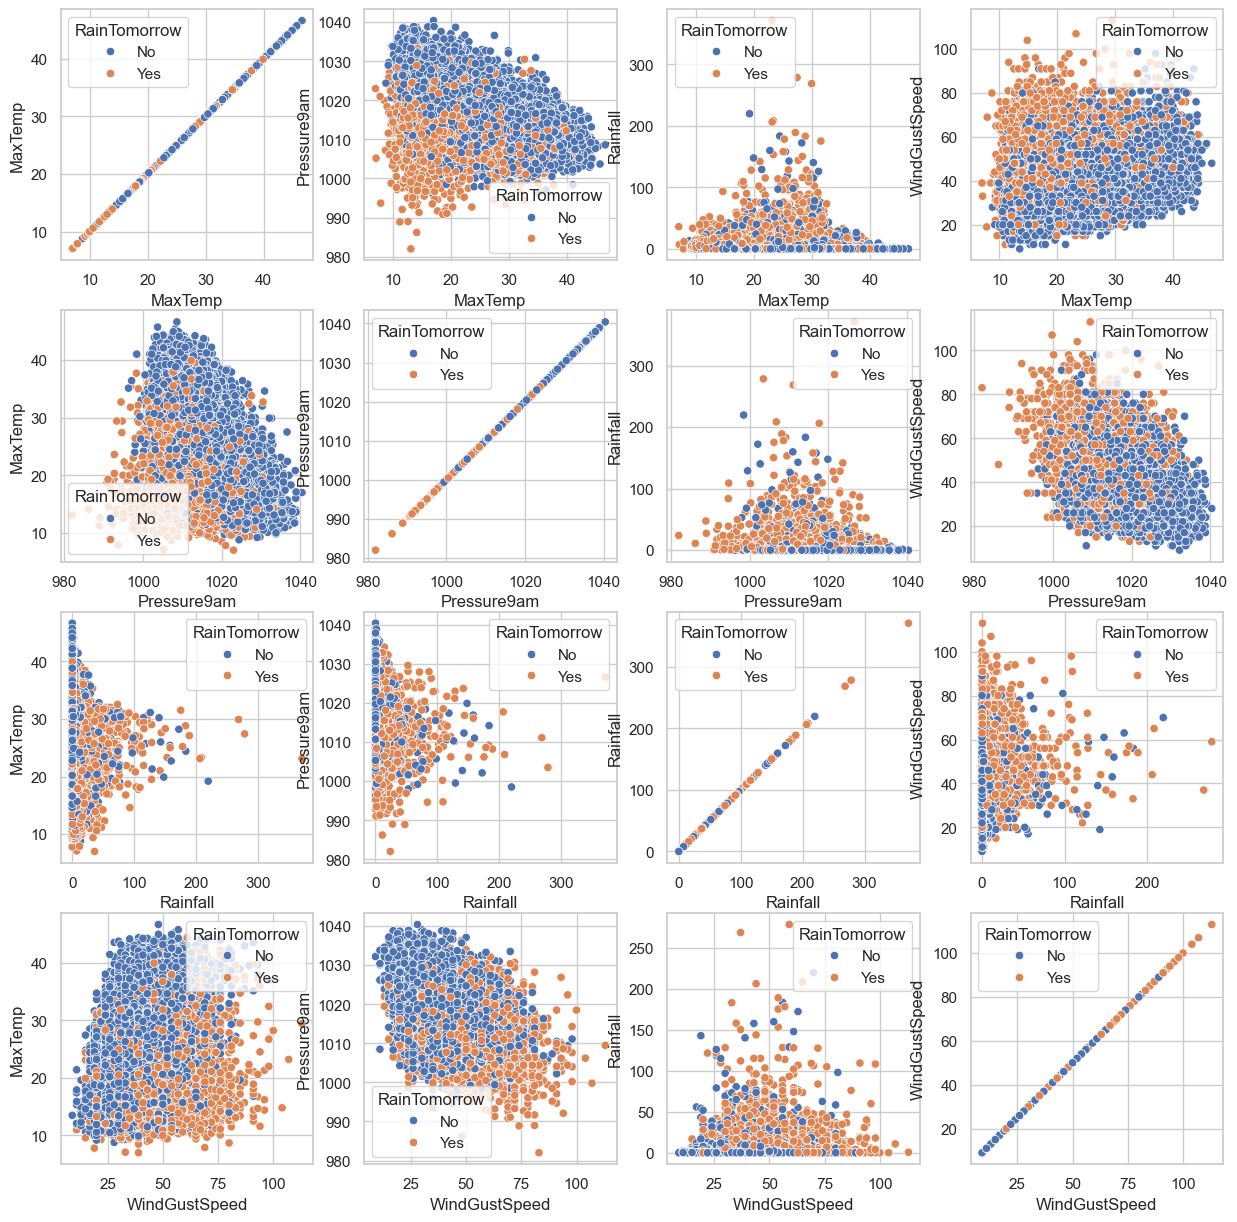

In [122]:
# Por la imposiblidad de ver todos los scatter plot posibles entre cuantitativas, se eligen
#3 features
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
columns = ['MaxTemp','Pressure9am','Rainfall','WindGustSpeed']
fig.subplots_adjust(hspace=0.2)
i = 0
for col in columns:
    j = 0
    for col2 in columns:
        #agregamos labels para usarlas luego
        sns.scatterplot(data=df_train, x=col, y=col2, hue="RainTomorrow",ax=axs[i,j]) 
        j+=1
    i+=1
plt.show()

En cualquier ubicación geográfica, Las condiciones meteorológicas que determinan una mayor probabilidad de lluvias son:
* Baja Presión
* Alta Temperatura + Alta Humedad

A partir de los gráficos de dispersión, se observa la posibilidad de trazar fácilmente una recta frontera en las gráficas, por ejemplo, Pressure9am vs MaxTemp, WindGustSpeed vs Pressure9am y WindGustSpeed vs MaxTemp para determinar la pertenencia a una clase de la target.

Al contrario, la feature RainFall no sirve para poder trazar una recta frontera junto a otra feature.

In [123]:
# Correlación entre variables cualitativas incluyendo la target
df_corr_rain_cuali = pd.DataFrame({
    'RainToday': ['RainToday_Yes','RainToday_Yes','RainToday_No','RainToday_No'],
    'RainTomorrow': ['RainTomorrow_Yes','RainTomorrow_No','RainTomorrow_Yes','RainTomorrow_No'],
    'Frec_abs': [None,None,None,None]
})
df_corr_rain_cuali.loc[0,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[1,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='No')])
df_corr_rain_cuali.loc[2,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[3,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='No')])

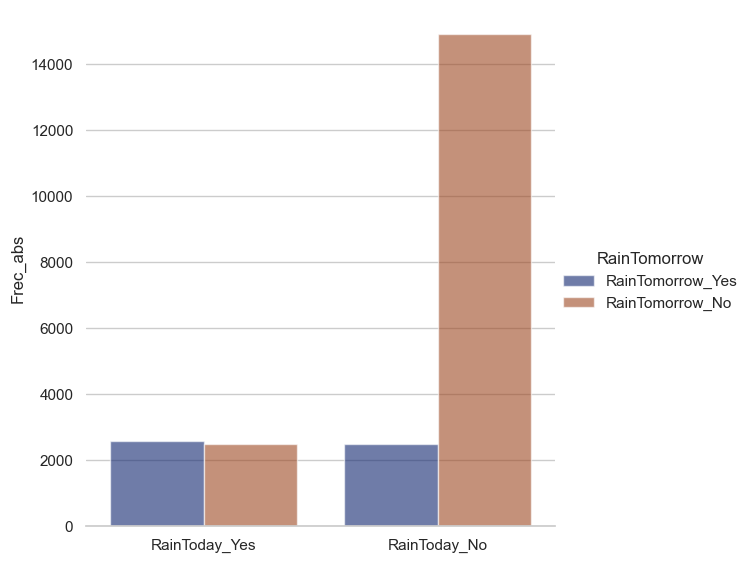

In [124]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df_corr_rain_cuali, kind="bar",
    x="RainToday", y="Frec_abs", hue="RainTomorrow",
    errorbar=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Frec_abs")
g.set_titles('Visualización de correlación entre variables cuantitativas')
plt.show()

Se puede observar la correlación que existe entre RainToday y RainTomorrow:
* Si hoy llueve es más probable que mañana también llueva.
* Si hoy no llueve, es altamente probable que mañana no llueva.

### Matriz de correlación de variables

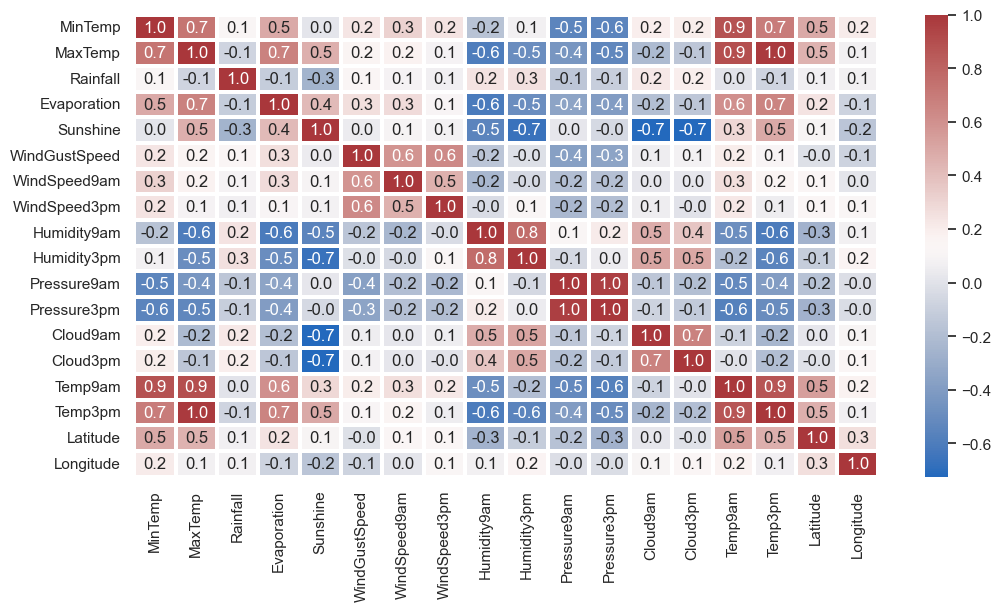

In [125]:
plt.figure(figsize=(12, 6))
sns.heatmap(data=df_train[features_cuanti].corr(),annot=True,fmt=".1f",linewidths=1.5,cmap='vlag')
plt.show()

La colinealidad es un razgo entre las features.

Por un lado, se observa una correlación lineal positiva fuerte entre variables meteorológicas que únicamente difieren en la hora del día en el que fueron registradas.

Por el otro, se verifica una correlación negativa de gran intensidad entre variables que naturalmente tienen comportamientos opuestos como la feature Sunshine y las features vinculadas con la medición de la nubosidad.

### Análisis de balanceo del dataset 

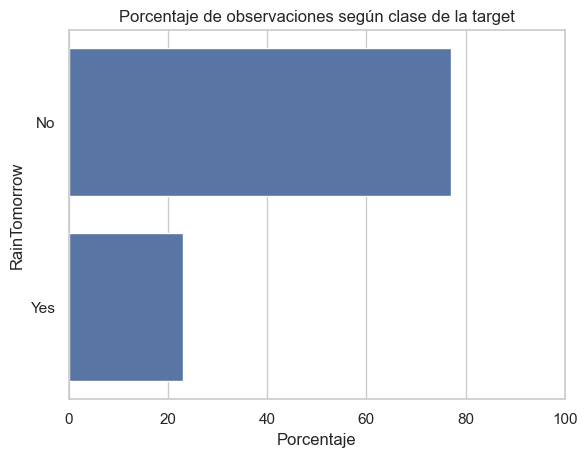

In [126]:
# Análisis de balanceo del df de entrenamiento
balanceo = round(y_train.value_counts() / len(y_train) *100,0)
sns.barplot(balanceo,orient='y')
plt.ylabel('RainTomorrow')
plt.xlabel('Porcentaje')
plt.xlim((0,100))
plt.title('Porcentaje de observaciones según clase de la target')
plt.show()

Clase RainTomorrow = no --> Clase negativa (mayoritaria)

Clase RainTomorrow = si --> Clase positiva (minoritaria)

El dataframe de entrenamiento no está balanceado debido a que más del 75% de las observaciones totales pertenecen a la variable target negativa. Es importante este análisis porque al estar desbalanceado corresponde aplicar las técnicas de oversampling, undersampling o discriminación de penalidad asignada a cada clase para evitar que modelo tienda a predecir la categoría mayoritaria.  

### Análisis y decisión sobre datos faltantes y atípicos

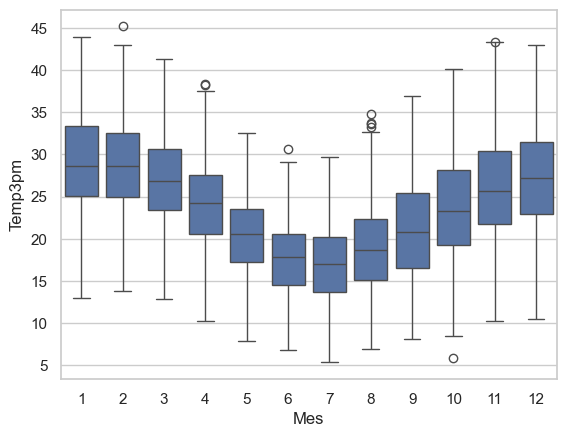

In [127]:
# Se analiza el caso de features que presentan un significativo comportamiento estacional
# y por ende puede que se justifique imputar faltantes aplicando un estadístico segmentado por mes
sns.boxplot(data=df_train,y='Temp3pm',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

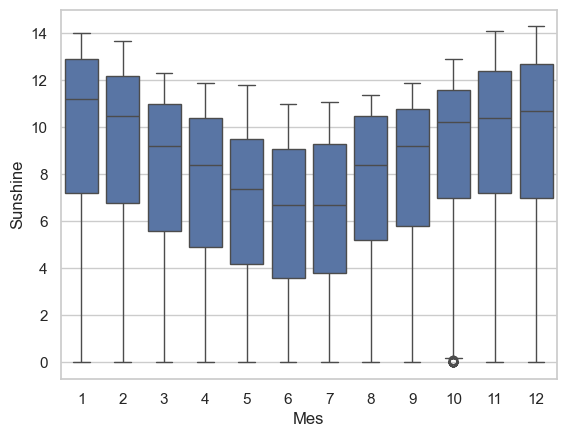

In [128]:
sns.boxplot(data=df_train,y='Sunshine',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

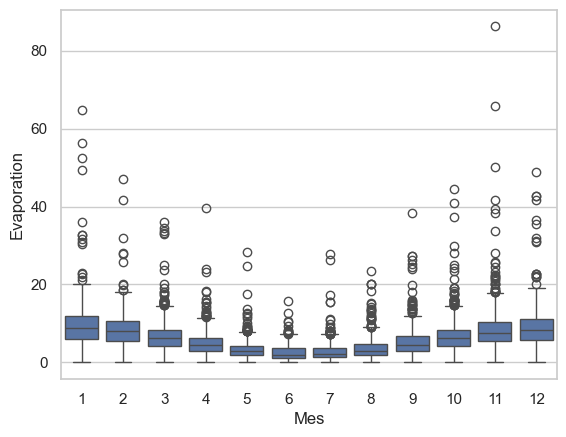

In [129]:
sns.boxplot(data=df_train,y='Evaporation',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

In [130]:
X_train.isna().sum()

Date                0
MinTemp            25
MaxTemp            17
Rainfall           94
Evaporation      7597
Sunshine         9842
WindGustDir       233
WindGustSpeed     221
WindDir9am       1020
WindDir3pm        100
WindSpeed9am       30
WindSpeed3pm       30
Humidity9am       239
Humidity3pm       244
Pressure9am        45
Pressure3pm        45
Cloud9am         9029
Cloud3pm         9425
Temp9am             7
Temp3pm            12
RainToday          94
Latitude            0
Longitude           0
Month               0
dtype: int64

Se decide el criterio para la imputación de las direcciones de vientos faltantes, basados en la consulta con un meteorólogo.

En la práctica, si falta la información de uno de los vientos, se completa el valor de alguno de los otros vientos del mismo día.
Esto no provoca fuga de datos porque es el procedimiento habitual en tiempo real.

Si faltan los valores de los 3 campos de direcciones de vientos, se imputan por la moda calculada en el conjunto de entrenamiento.

No se procede de igual manera para otras variables, por ejemplo, no se imputan los valores faltantes de la temperatura de las 9am con las de las 3pm debido al rango variación de sus valores. 

En estos casos, es preferible imputar por el promedio de los días próximos. En nuestro caso, imputamos por el promedio mensual o por la mediana, dependiendo del comportamiento de cada variable.

In [131]:
# Tratamiento de faltantes en features con una alta proporción de valores faltantes
# que justifican imputar por media segmentada
X_train_media_seg_sunshine_by_mes = X_train.groupby(X_train['Date'].dt.month)['Sunshine'].transform('mean')
X_train_media_seg_cloud9am_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud9am'].transform('mean')
X_train_media_seg_cloud3pm_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud3pm'].transform('mean')
X_train_media_seg_evaporation_by_mes = X_train.groupby(X_train['Date'].dt.month)['Evaporation'].transform('mean')
X_train_imputed = X_train.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})
X_test_imputed = X_test.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})

In [132]:
# Función para imputar valores en las columnas de dirección del viento
def impute_wind_directions(row):
    if pd.notna(row['WindGustDir']):
        # Si WindGustDir no es nulo, imputar WindDir9am y WindDir3pm con ese valor
        if pd.isna(row['WindDir9am']):
            row['WindDir9am'] = row['WindGustDir']
        if pd.isna(row['WindDir3pm']):
            row['WindDir3pm'] = row['WindGustDir']
    else:
        # Si WindGustDir es nulo, imputar con los valores entre WindDir9am y WindDir3pm
        if pd.notna(row['WindDir9am']):
            row['WindGustDir'] = row['WindDir9am']
            if pd.isna(row['WindDir3pm']):
                row['WindDir3pm'] = row['WindDir9am']
        elif pd.notna(row['WindDir3pm']):
            row['WindGustDir'] = row['WindDir3pm']
            if pd.isna(row['WindDir9am']):
                row['WindDir9am'] = row['WindDir3pm']
    return row

# Aplicar la función a los DataFrames
X_train_imputed = X_train_imputed.apply(impute_wind_directions, axis=1)
X_test_imputed = X_test_imputed.apply(impute_wind_directions, axis=1)

In [133]:
# Tratamiento de faltantes en features cualitativas
X_train_moda_dir_nudo_viento = X_train['WindGustDir'].mode()[0]
X_train_moda_dir_viento9am = X_train['WindDir9am'].mode()[0]
X_train_moda_dir_viento3pm = X_train['WindDir3pm'].mode()[0]
X_train_moda_raintoday = X_train['RainToday'].mode()[0]
X_train_imputed = X_train_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})

In [134]:
# Reducción de la cantidad de categorías correspondientes con la dirección del viento. De 16 a 4.
direction_dict = {
    'SSW':'S',
    'S':'S',
    'SE':'S',
    'NNE':'N',
    'WNW':'W',
    'N':'N',
    'ENE':'E',
    'NE':'N',
    'E':'E',
    'SW':'S',
    'W':'W',
    'WSW':'W',
    'NNW':'N',
    'ESE':'E',
    'SSE':'S',
    'NW':'N'
}
for feature_cuali in features_cuali[:3]:
    X_train_imputed[feature_cuali] = X_train_imputed[feature_cuali].map(direction_dict)
    X_test_imputed[feature_cuali] = X_test_imputed[feature_cuali].map(direction_dict)
X_train_imputed.loc[0]

Date             2016-06-01 00:00:00
MinTemp                         11.9
MaxTemp                         23.2
Rainfall                         0.0
Evaporation                      2.6
Sunshine                    6.147587
WindGustDir                        E
WindGustSpeed                   30.0
WindDir9am                         E
WindDir3pm                         E
WindSpeed9am                     7.0
WindSpeed3pm                    19.0
Humidity9am                     77.0
Humidity3pm                     61.0
Pressure9am                   1020.9
Pressure3pm                   1018.4
Cloud9am                    4.303057
Cloud3pm                    4.351699
Temp9am                         17.4
Temp3pm                         22.4
RainToday                         No
Latitude                     -23.698
Longitude                   133.8807
Month                            jun
Name: 0, dtype: object

In [135]:
# Tratamiento de faltantes en features asimétricas que justican imputar por mediana simple
X_train_mediana_WindGustSpeed = X_train['WindGustSpeed'].median()
X_train_mediana_Humidity9am = X_train['Humidity9am'].median()
X_train_mediana_Humidity3pm = X_train['Humidity3pm'].median()
X_train_mediana_Rainfall = X_train['Rainfall'].median()
X_train_mediana_WindSpeed9am = X_train['WindSpeed9am'].median()
X_train_mediana_WindSpeed3pm = X_train['WindSpeed3pm'].median()
X_train_mediana_Pressure9am  = X_train['Pressure9am'].median()
X_train_mediana_Pressure3pm = X_train['Pressure3pm'].median()

X_train_imputed = X_train_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})

In [136]:
# Tratamiento de faltantes en features simétricas que justican imputar por media simple
X_train_mean_MinTemp = X_train['MinTemp'].mean()
X_train_mean_MaxTemp = X_train['MaxTemp'].mean()
X_train_mean_Temp9am = X_train['Temp9am'].mean()
X_train_mean_Temp3pm = X_train['Temp3pm'].mean()


X_train_imputed = X_train_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})

In [137]:
X_train_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Latitude         0
Longitude        0
Month            0
dtype: int64

In [138]:
X_test_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Latitude         0
Longitude        0
Month            0
dtype: int64

Tratamiento de valores atípicos para la feature Rainfall.

La lluvia presenta una significatía asimetría positiva. Para evitar distorsiones sobre el valor de los parámetros del modelo, se imputan los valores atípicos de esta variable en base al mayor valor típico observado para la variable en cuestión.

In [139]:
s_lluvia = X_train_imputed[X_train_imputed['Rainfall']>0]['Rainfall']
q1 , q3 = s_lluvia.quantile(q=[0.25,0.75])
r_i = q3 - q1
valor_tipico_sup = q3 + 1.5 * r_i
# Imputacion para train
X_train_imputed_idx_lluvia_ati = X_train_imputed[X_train_imputed['Rainfall']>valor_tipico_sup].index
X_train_imputed.loc[X_train_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup
# Imputacion para test
X_test_encoded_imputed_idx_lluvia_ati = X_test_imputed[X_test_imputed['Rainfall']>valor_tipico_sup].index
X_test_imputed.loc[X_test_encoded_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup

### Codificación de variables categóricas

In [140]:
def codificar_features_cuanti(data_set,col_catego):
    """Recibe un data frame y sus columnas categoricas y 
    devuelve el data frame transformado con la correspondiente 
    codificación de estas columnas"""
    encoder = OneHotEncoder(sparse_output=False,drop='first')
    one_hot_encoded = encoder.fit_transform(data_set[col_catego])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(col_catego))
    df_encoded = pd.concat([data_set, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(col_catego, axis=1)
    return df_encoded


In [141]:
def codificar_target(serie:pd.Series):
    """Recibe una serie para cambiar el nombre y a su vez mapear 
    sus valores para codificarlos"""
    serie.name ='RainTomorrow_Yes'
    serie_codificada =  serie.map({"No":0,"Yes":1})
    return serie_codificada

In [142]:
# Codificación de features categóricas
X_train_encoded_imputed = codificar_features_cuanti(X_train_imputed,features_cuali)
X_test_encoded_imputed = codificar_features_cuanti(X_test_imputed,features_cuali)

In [143]:
X_train_encoded_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Latitude         0
Longitude        0
WindGustDir_N    0
WindGustDir_S    0
WindGustDir_W    0
WindDir9am_N     0
WindDir9am_S     0
WindDir9am_W     0
WindDir3pm_N     0
WindDir3pm_S     0
WindDir3pm_W     0
RainToday_Yes    0
Month_ago        0
Month_dic        0
Month_ene        0
Month_feb        0
Month_jul        0
Month_jun        0
Month_mar        0
Month_may        0
Month_nov        0
Month_oct        0
Month_sep        0
dtype: int64

In [144]:
#Codificación de la target 
y_train_encoded = codificar_target(y_train)
y_test_encoded = codificar_target(y_test)
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

In [145]:
X_train_encoded_imputed.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Latitude', 'Longitude', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
       'RainToday_Yes', 'Month_ago', 'Month_dic', 'Month_ene', 'Month_feb',
       'Month_jul', 'Month_jun', 'Month_mar', 'Month_may', 'Month_nov',
       'Month_oct', 'Month_sep'],
      dtype='object')

In [146]:
print("X_train_imputed\n",X_train_imputed.head(5))
print("X_train_encoded_imputed\n",X_train_encoded_imputed.head(5))

X_train_imputed
         Date  MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine WindGustDir  \
0 2016-06-01     11.9     23.2       0.0          2.6   6.147587           E   
1 2009-10-13      8.9     20.7       0.0          4.2   8.500000           W   
2 2009-02-28     22.2     36.9       0.0          9.4  12.000000           W   
3 2014-09-12      8.7     21.9       0.0          6.2   7.965803           S   
4 2016-01-22     16.5     30.4       0.0          8.2  13.100000           E   

   WindGustSpeed WindDir9am WindDir3pm  ...  Pressure9am  Pressure3pm  \
0           30.0          E          E  ...       1020.9       1018.4   
1           41.0          S          W  ...       1025.8       1022.8   
2           41.0          N          W  ...       1010.9       1008.1   
3           33.0          E          S  ...       1017.4       1014.8   
4           39.0          E          S  ...       1018.2       1014.8   

   Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  Latitude  L

### Escalado de datos 

In [147]:
# Escalado de datos - NO SE ESCALAN VARIABLES CUALITATIVAS
scaler = StandardScaler()
X_train_encoded_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)
X_test_encoded_imputed_scaled = pd.DataFrame(scaler.transform(X_test_encoded_imputed[features_cuanti]), columns=features_cuanti)


In [148]:
# Primero se filtra para eliminar las cuantitativas no escaladas para luego unir 
# las cualitativas con las cuantitativas sí escaladas
X_train_encoded_imputed_cuali = X_train_encoded_imputed.drop(features_cuanti,axis=1)
X_train_encoded_imputed_cuantiscaled_cuali = pd.concat([X_train_encoded_imputed_scaled,X_train_encoded_imputed_cuali],axis=1)

X_test_encoded_imputed_cuali = X_test_encoded_imputed.drop(features_cuanti,axis=1)
X_test_encoded_imputed_cuantiscaled_cuali = pd.concat([X_test_encoded_imputed_scaled,X_test_encoded_imputed_cuali],axis=1)

In [149]:
X_train_encoded_imputed_cuantiscaled_cuali 
y_test_encoded
X_test_encoded_imputed_cuantiscaled_cuali 
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

In [150]:
#Observo columnas de X_train_encoded_imputed_cuantiscaled_cuali
print(X_train_encoded_imputed_cuantiscaled_cuali.columns)
print("Cant. de columnas: ", len(X_train_encoded_imputed_cuantiscaled_cuali.columns))

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Latitude', 'Longitude', 'Date', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
       'RainToday_Yes', 'Month_ago', 'Month_dic', 'Month_ene', 'Month_feb',
       'Month_jul', 'Month_jun', 'Month_mar', 'Month_may', 'Month_nov',
       'Month_oct', 'Month_sep'],
      dtype='object')
Cant. de columnas:  40


In [151]:
# Eliminar la columna 'Date' de los conjuntos ( nos quedamos con los meses)
x_train_clean = X_train_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])
x_test_clean = X_test_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])

# No es necesario modificar y_train y y_test
y_train_clean = y_train_encoded
y_test_clean = y_test_encoded

In [152]:
# Mostrar las dimensiones de X_train_clean
print("Dimensiones de X_train_clean:", x_train_clean.shape)
print("Dimensiones de y_train_clean:", y_train_clean.shape)   # Mostrar las dimensiones de y_train_clean
print("Dimensiones de X_test_clean:", x_test_clean.shape)
print("Dimensiones de y_test_clean:", y_test_clean.shape)


Dimensiones de X_train_clean: (22253, 39)
Dimensiones de y_train_clean: (22253,)
Dimensiones de X_test_clean: (5647, 39)
Dimensiones de y_test_clean: (5647,)


## 2. Regresión Logística

Se implementan distintos modelos a los fines de poder comparar las distintas técnicas de optimización:

1 - Modelo de Regresión Logística Básico.

2- Modelo de Regresión Logística Balanceado con Regularización Ridge.

3- Modelo de Regresión Logística Balanceado con Regularización Lasso.

4- Predicciones finales usando los umbrales óptimos.


### Regresión Logistica Base (Sin balancear)

In [153]:
# Entrenamos Regresion Logistica básica sin ajustar parametros.
logistic_model = LogisticRegression(penalty=None, random_state=42)
logistic_model.fit(x_train_clean, y_train_clean)
y_pred = logistic_model.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred))
print(confusion_matrix(y_test_clean, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4373
           1       0.75      0.56      0.64      1274

    accuracy                           0.86      5647
   macro avg       0.82      0.75      0.78      5647
weighted avg       0.85      0.86      0.85      5647

[[4139  234]
 [ 558  716]]


$$
\text{Pondered Accuracy} = \frac{1}{3} \left( \frac{2 * TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$


Se define la métrica pondered_accuracy que duplica la ponderación del Recall Clase 1 (FN) con respocto al Recall Clase 0. 

Es la métrica que se tratará de optimizar.

In [154]:

def pondered_accuracy(y_true, y_pred):
    recall_scorer_0 = recall_score(y_true, y_pred, pos_label=0)
    recall_scorer_1 = recall_score(y_true, y_pred, pos_label=1)
    return (2 * recall_scorer_1 + recall_scorer_0) / 3


In [155]:
# Calcular Pondered Accuracy
pondered_accuracy_rl = pondered_accuracy(y_test_clean, y_pred)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_rl:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.6902


In [156]:
cf_matrix = confusion_matrix(y_test_clean, y_pred)

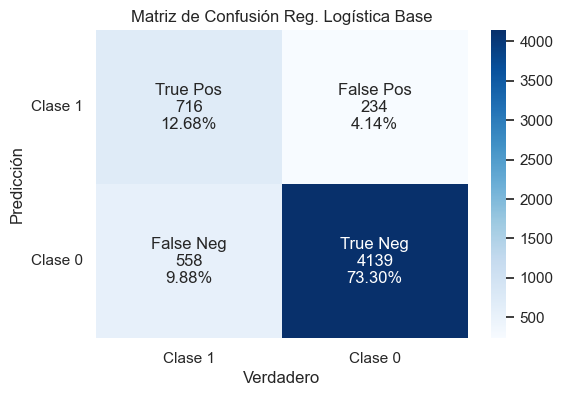

In [157]:
# Reordenamos la matriz de confusión para que tenga TP y FP en la primera fila, FN y TN en la segunda fila
cf_matrix_reordered = np.array([[cf_matrix[1, 1], cf_matrix[0, 1]],  # TP y FP
                                [cf_matrix[1, 0], cf_matrix[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered.flatten() / np.sum(cf_matrix_reordered)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Base', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

Análisis de matriz de confusión:

TN = 4138 Casos donde no llueve y predice que no llueve.

FP = 235 Casos donde no llueve pero predice que llueve.

FN = 559 Casos donde llueve pero predice que no llueve.

TP = 715 Casos donde llueve y predice que llueve correctamente.

##### Curva ROC y AUC 

In [158]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reglog= logistic_model.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_test_clean, y_probs_reglog)
roc_auc_rl = auc(fpr_rl, tpr_rl)

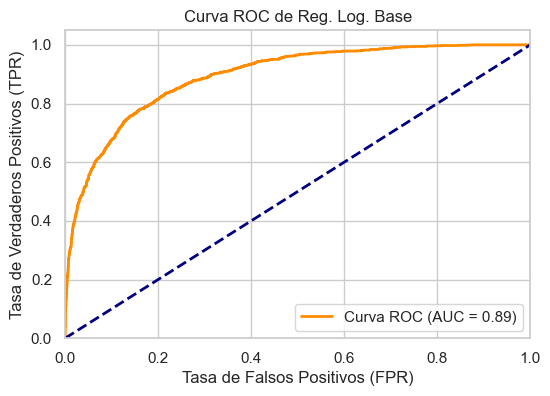

In [159]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_rl, tpr_rl, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_rl)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Base')
plt.legend(loc="lower right")
plt.show()

### Regresión Logística Balanceada con Regularización Ridge.

Class_weight = 'balanced' le asigna pesos distintos en el cálculo de costo para cada clase. En este caso, como la relación de datos es aprox. 77% (clase 0) / 23% (clase minoritaria 1) , el peso para la clase "1" será aproximadamente 3.35 veces mayor que el peso para la clase "0" (penaliza aprox. 3,35 veces más a la clase minoritaria que el de la clase mayoritaria.)

In [160]:
logistic_model_balanced = LogisticRegression(penalty='l2', random_state=42, class_weight= "balanced")
logistic_model_balanced.fit(x_train_clean, y_train_clean)
y_pred_balanced = logistic_model_balanced.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred_balanced))
print(confusion_matrix(y_test_clean, y_pred_balanced))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.55      0.81      0.65      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647

[[3521  852]
 [ 243 1031]]


In [161]:
# Calcular Pondered Accuracy
pondered_accuracy_balanced = pondered_accuracy(y_test_clean, y_pred_balanced)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_balanced:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.8079


In [162]:
cf_matrix_b = confusion_matrix(y_test_clean, y_pred_balanced)

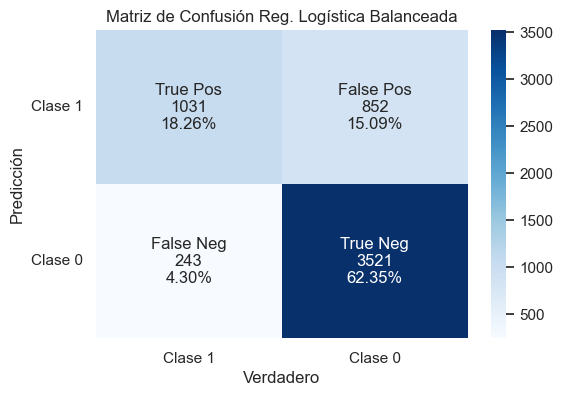

In [163]:
cf_matrix_reordered_b = np.array([[cf_matrix_b[1, 1], cf_matrix_b[0, 1]],  # TP y FP
                                [cf_matrix_b[1, 0], cf_matrix_b[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered_b.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered_b.flatten() / np.sum(cf_matrix_reordered_b)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered_b, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

##### Curva ROC y AUC 

In [164]:
# Obtengo las probabilidades de predicción del modelo
y_probs_balanced = logistic_model_balanced.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_ba, tpr_ba, thresholds_ba = roc_curve(y_test_clean, y_probs_balanced)
roc_auc = auc(fpr_ba, tpr_ba)

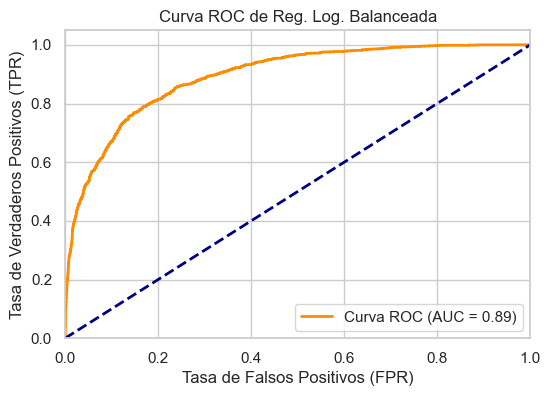

In [165]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_ba, tpr_ba, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada')
plt.legend(loc="lower right")
plt.show()

### Regresión Log. Balanceada con Regularización Lasso

In [166]:
# Crear un modelo de regresión logística con regularización L1 (Lasso)
# Ajusta el valor de 'C' para controlar la fuerza de la regularización (menos es más regularización)
# Un valor más pequeño de C=1/λ aumentará la regularización

logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=1, solver='saga',random_state=42, class_weight= "balanced")
#logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=0.5, solver='saga',random_state=42, class_weight= "balanced")
#logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=1.5, solver='saga',random_state=42, class_weight= "balanced")

# Entrenar el modelo con tus datos de entrenamiento
logistic_model_balanced_regul.fit(x_train_clean, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_pred_reg = logistic_model_balanced_regul.predict(x_test_clean)

In [167]:
# Generar un informe de clasificación
reporte_clasificacion = classification_report(y_test_clean, y_pred_reg)
print("Informe de Clasificación:")
print(reporte_clasificacion)

# Calcular la matriz de confusión
matriz_confusion_regularizacion = confusion_matrix(y_test_clean, y_pred_reg)
print("Matriz de Confusión:")
print(matriz_confusion_regularizacion)

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.55      0.81      0.65      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647

Matriz de Confusión:
[[3522  851]
 [ 243 1031]]


In [168]:
# Calcular Pondered Accuracy
pondered_accuracy_reg = pondered_accuracy(y_test_clean, y_pred_reg)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_reg:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.8080


In [169]:
cf_matrix_reg = confusion_matrix(y_test_clean, y_pred_reg)

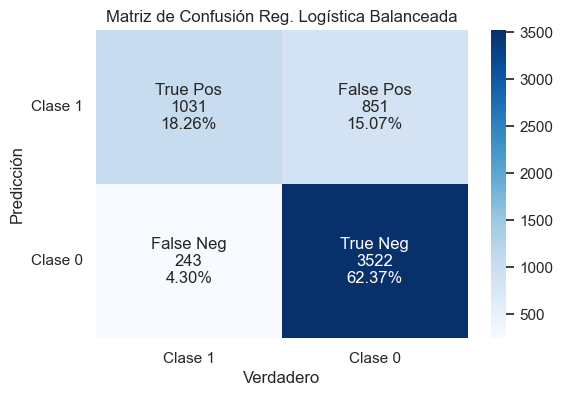

In [170]:
cf_matrix_reordered_reg = np.array([[cf_matrix_reg[1, 1], cf_matrix_reg[0, 1]],  # TP y FP
                                [cf_matrix_reg[1, 0], cf_matrix_reg[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered_reg.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered_reg.flatten() / np.sum(cf_matrix_reordered_reg)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered_reg, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

##### Curva ROC y AUC 

In [171]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reg= logistic_model_balanced_regul.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_re, tpr_re, thresholds_re = roc_curve(y_test_clean, y_probs_reg)
roc_auc_re = auc(fpr_re, tpr_re)

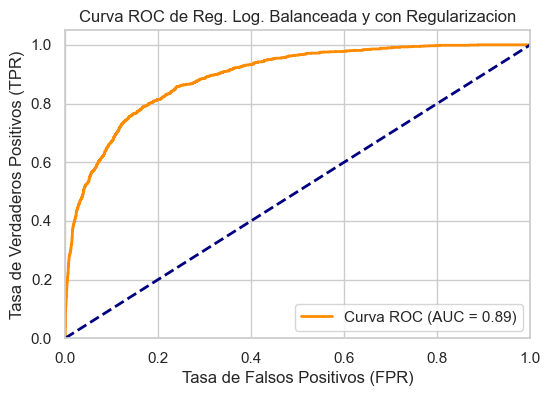

In [172]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_re, tpr_re, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_re)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada y con Regularizacion')
plt.legend(loc="lower right")
plt.show()

## 3. Modelos Base (Ingenuos) 

### Modelo Base Naive Bayes.

El clasificador Naive Bayes se considera "ingenuo" debido a la suposición simplificada que hace sobre la independencia de las características. GaussianNB: para características numéricas continuas (como temperatura, humedad, etc.) que pueden seguir una distribución normal.

In [173]:
from sklearn.naive_bayes import GaussianNB

# Crear el clasificador Naive Bayes
naive_bayes_model = GaussianNB()

# Entrenar el modelo
naive_bayes_model.fit(x_train_clean, y_train_clean)

# Hacer predicciones en el conjunto de prueba
y_pred_nb = naive_bayes_model.predict(x_test_clean)


In [174]:
# Mostrar el reporte de clasificación
print("Resultados de Naive Bayes:\n")
print(classification_report(y_test_clean, y_pred_nb))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_nb))
cf_matrix_nb= confusion_matrix(y_test_clean, y_pred_nb)


Resultados de Naive Bayes:

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4373
           1       0.56      0.69      0.62      1274

    accuracy                           0.81      5647
   macro avg       0.73      0.77      0.75      5647
weighted avg       0.83      0.81      0.82      5647

Matriz de Confusión:

[[3694  679]
 [ 397  877]]


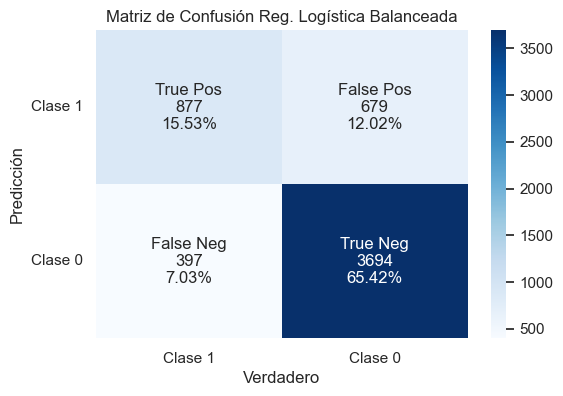

In [175]:
cf_matrix_reordered_nb = np.array([[cf_matrix_nb[1, 1], cf_matrix_nb[0, 1]],  # TP y FP
                                [cf_matrix_nb[1, 0], cf_matrix_nb[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered_nb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered_nb.flatten() / np.sum(cf_matrix_reordered_nb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered_nb, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

In [176]:
# Calcular Pondered Accuracy
pondered_accuracy_nb = pondered_accuracy(y_test_clean, y_pred_nb)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_nb:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.7405


In [177]:
# Obtengo las probabilidades de predicción del modelo
y_probs_nb = naive_bayes_model.predict_proba(x_test_clean)[:, 1]

# Calculo la ROC y el AUC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_clean, y_probs_nb)
roc_auc = auc(fpr_nb, tpr_nb)

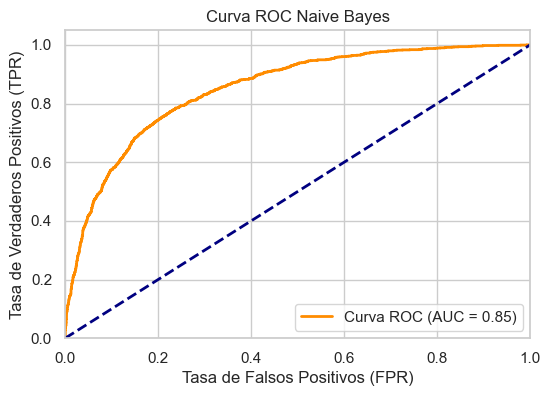

In [178]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Naive Bayes')
plt.legend(loc="lower right")
plt.show()

### Modelo Base: Basado en valor de variable Humedad (Humidity3pm).

In [179]:
media = X_train_imputed['Humidity3pm'].mean()
std = X_train_imputed['Humidity3pm'].std()
valor_60_escalado = (60-media) / std
valor_60_escalado

np.float64(0.4578588657783258)

In [180]:
y_pred_humidity = x_test_clean['Humidity3pm'].apply(lambda x:1 if x>valor_60_escalado else 0)
y_pred_humidity

0       0
1       1
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: Humidity3pm, Length: 5647, dtype: int64

In [181]:
y_pred_humidity.value_counts()

Humidity3pm
0    3562
1    2085
Name: count, dtype: int64

In [182]:
# Mostrar el reporte de clasificación
print("Resultados de Baseline por Humidity:\n")
print(classification_report(y_test_clean, y_pred_humidity))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_humidity))

Resultados de Baseline por Humidity:

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      4373
           1       0.46      0.75      0.57      1274

    accuracy                           0.74      5647
   macro avg       0.68      0.75      0.69      5647
weighted avg       0.81      0.74      0.76      5647

Matriz de Confusión:

[[3245 1128]
 [ 317  957]]


In [183]:
# Calcular Pondered Accuracy
pondered_accuracy_humidity = pondered_accuracy(y_test_clean, y_pred_humidity)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_humidity:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.7481


In [184]:
cf_matrix_h= confusion_matrix(y_test_clean, y_pred_humidity)

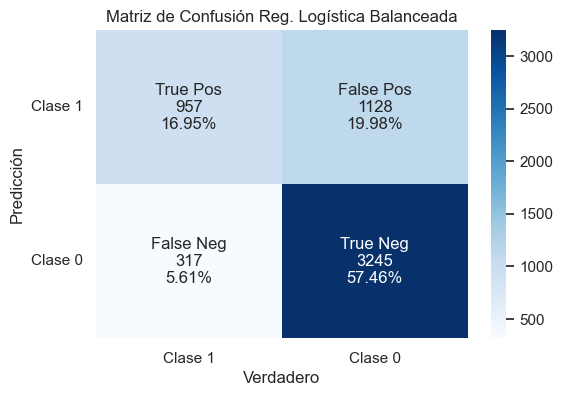

In [185]:
cf_matrix_reordered_h = np.array([[cf_matrix_h[1, 1], cf_matrix_h[0, 1]],  # TP y FP
                                [cf_matrix_h[1, 0], cf_matrix_h[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered_h.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered_h.flatten() / np.sum(cf_matrix_reordered_h)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered_h, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

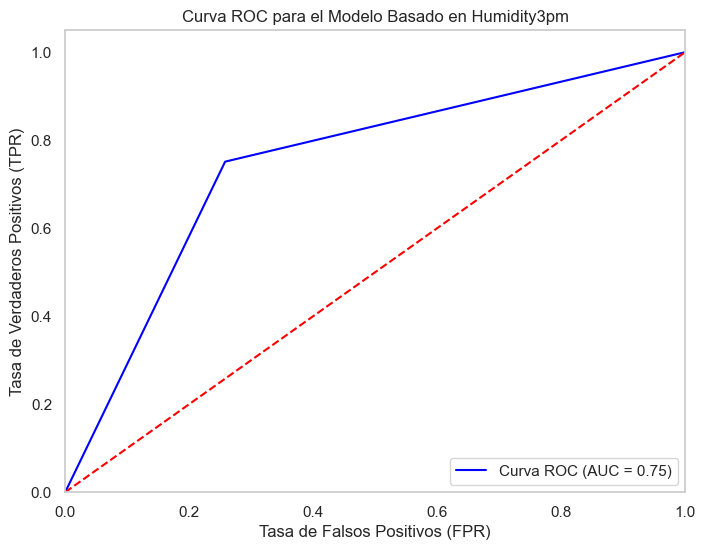

In [186]:
# Calcular las probabilidades para la curva ROC
# Asumimos que el valor de umbral para la clase positiva es valor_60_escalado
y_probs_humidity = y_pred_humidity.astype(int)

# Calcular FPR y TPR
fpr_hum, tpr_hum, thresholds_hum = roc_curve(y_test_clean, y_probs_humidity)

# Calcular el AUC
roc_auc_humidity = auc(fpr_hum, tpr_hum)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_hum, tpr_hum, color='blue', label=f'Curva ROC (AUC = {roc_auc_humidity:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el Modelo Basado en Humidity3pm')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Comparación de Modelos

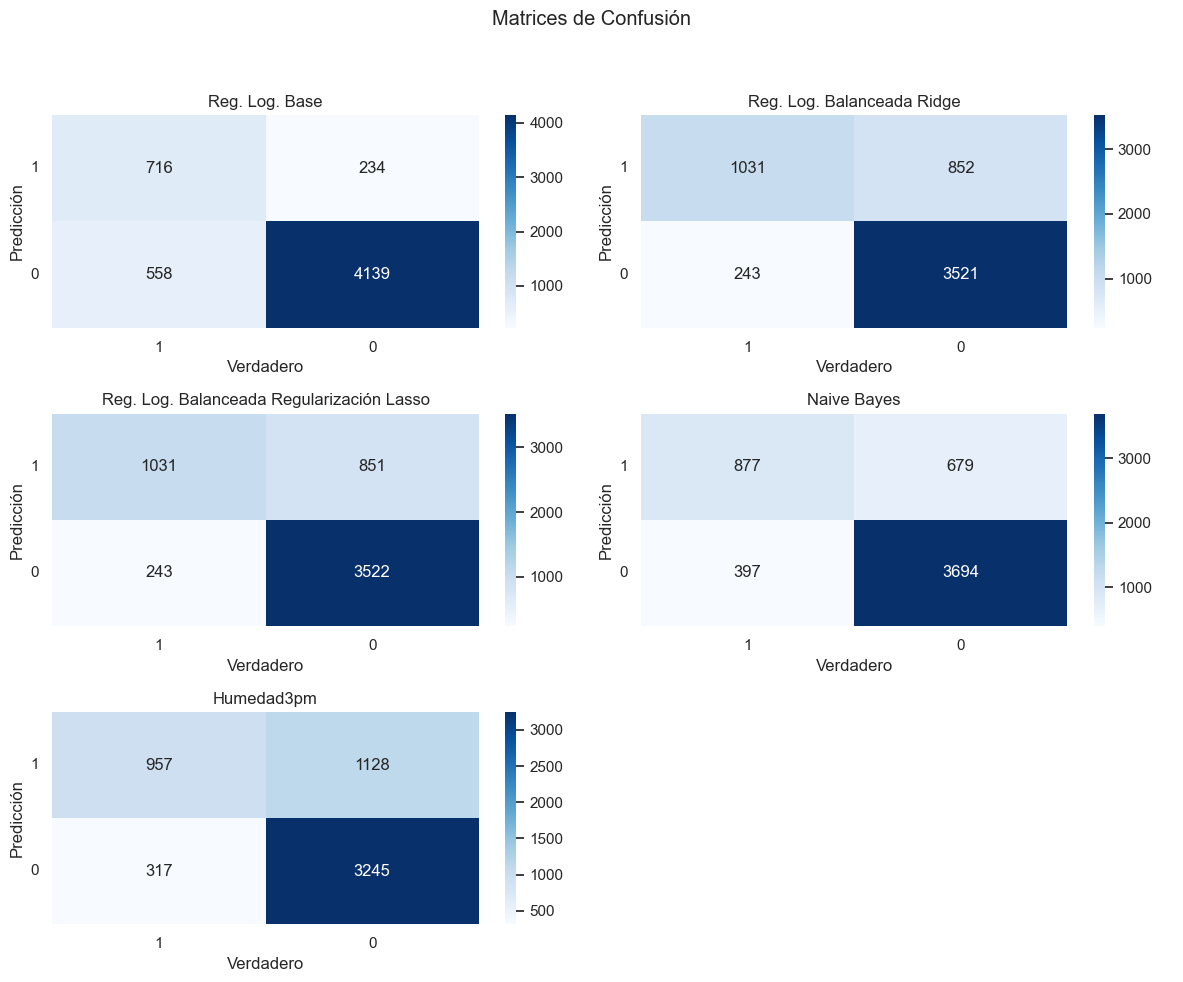

In [187]:

# Listado de matrices y títulos
matrices = [cf_matrix_reordered, cf_matrix_reordered_b, cf_matrix_reordered_reg, cf_matrix_reordered_nb, cf_matrix_reordered_h]
titles = ["Reg. Log. Base", "Reg. Log. Balanceada Ridge", "Reg. Log. Balanceada Regularización Lasso", "Naive Bayes", "Humedad3pm"]

# Configurar la figura con subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
# Título para toda la figura
fig.suptitle("Matrices de Confusión")
# fig.suptitle("Matrices de Confusión", fontsize=16)

# Iterar sobre cada matriz y el subplot correspondiente
for i, ax in enumerate(axes.ravel()):
    if i < len(matrices):  # Asegúrate de que haya una matriz disponible para cada subplot
        matrix = matrices[i]
        # Crear etiquetas personalizadas
        labels = ["TP", "FP", "FN", "TN"]
        group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
        labels_custom = [f"{v1}\n{v2}" for v1, v2 in zip(labels, group_counts)]
        labels_custom = np.asarray(labels_custom).reshape(2, 2)
        # Graficar la matriz reordenada
        # sns.heatmap(matrix, annot=labels_custom, fmt="", cmap="Blues", ax=ax, cbar=True, square=True)
        sns.heatmap(matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(titles[i])
        ax.set_xlabel("Verdadero")
        ax.set_ylabel("Predicción")
        # Etiquetas de clase en los ejes
        ax.set_xticklabels(['1', '0'])
        ax.set_yticklabels(['1', '0'], rotation=0)
    else:
        ax.axis('off')  # Apagar cualquier subplot vacío

# Ajusta la disposición de los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


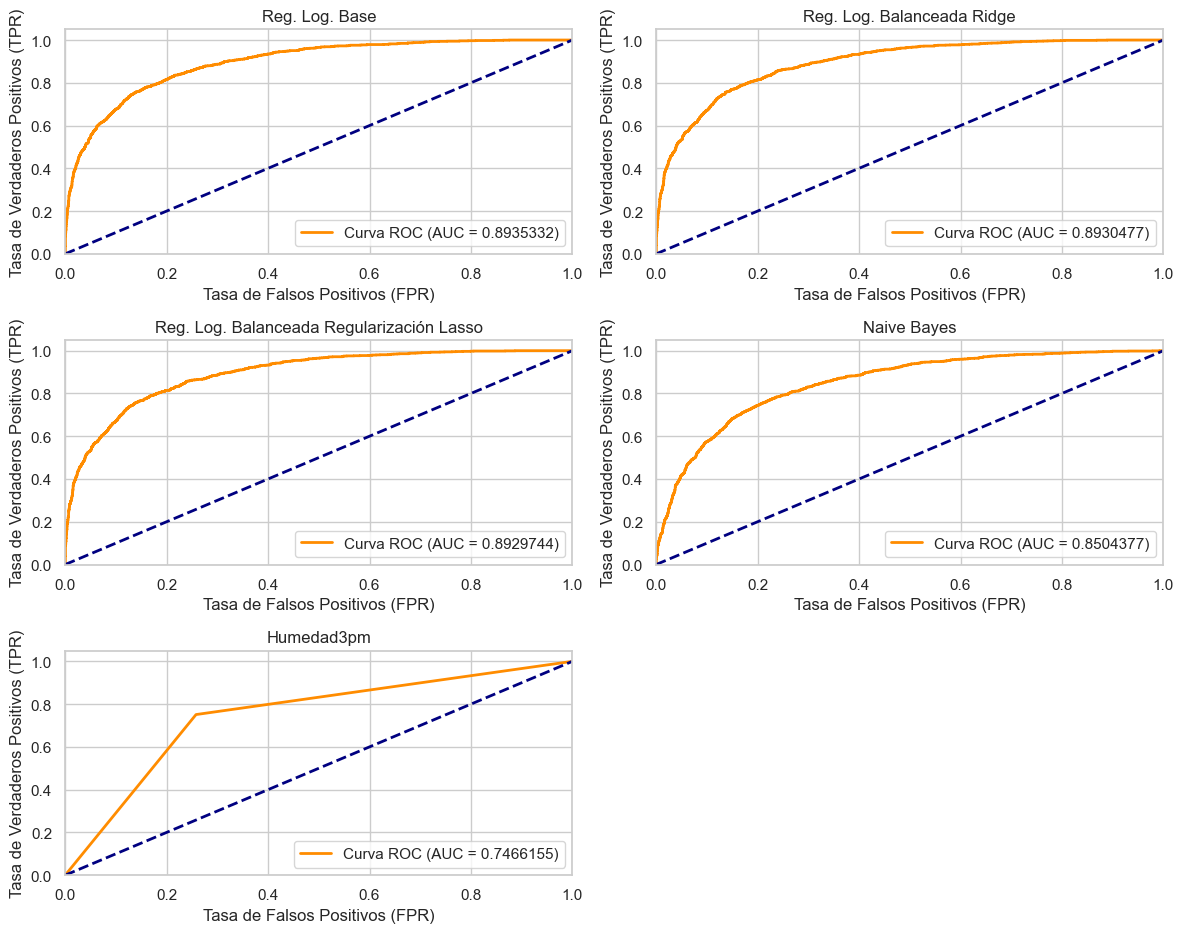

In [188]:
# Crear una figura con cuatro subgráficos
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Títulos para cada subgráfico
titles = ["Reg. Log. Base", "Reg. Log. Balanceada Ridge", "Reg. Log. Balanceada Regularización Lasso", "Naive Bayes", "Humedad3pm"]

# Probabilidades y etiquetas de prueba para cada modelo
y_probs_modelos = [y_probs_reglog, y_probs_balanced, y_probs_reg, y_probs_nb, y_probs_humidity]

for i, ax in enumerate(axes.ravel()):
    if i < len(y_probs_modelos):  # Verifica que haya y_probs_modelos disponibles
        fpr, tpr, thresholds = roc_curve(y_test_clean, y_probs_modelos[i])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc)
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
        ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
        ax.set_title(titles[i])
        ax.legend(loc="lower right")
    else:
        ax.axis('off')  # Oculta el subplot vacío

# Ajusta la disposición de los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [189]:
# Generar los informes de clasificación
report_reglog = classification_report(y_test_clean, y_pred, output_dict=True)
report_balanced = classification_report(y_test_clean, y_pred_balanced, output_dict=True)
report_regularized = classification_report(y_test_clean, y_pred_reg, output_dict=True)
report_base_nb = classification_report(y_test_clean, y_pred_nb, output_dict=True)
report_base_humidity = classification_report(y_test_clean, y_pred_humidity, output_dict=True)

#### Cuadro comparativo métricas.

Realizamos una observación general de todas las métricas.

In [190]:
# Extraer las métricas ( crea del df de métricas )
metrics = {
    "Modelo": [
        "Regresión Logística Base", 
        "Regres. Log. Balanceada Ridge", 
        "Reg. Log. Balanceada Lasso", 
        "Naive Bayes",
        "Modelo Base Humidity"
    ],
    "Accuracy": [
        report_reglog["accuracy"],
        report_balanced["accuracy"],
        report_regularized["accuracy"],
        report_base_nb["accuracy"],
        report_base_humidity["accuracy"]
    ],
    "Precision (Clase 0)": [
        report_reglog["0"]["precision"],
        report_balanced["0"]["precision"],
        report_regularized["0"]["precision"],
        report_base_nb["0"]["precision"],
        report_base_humidity["0"]["precision"]
    ],
    "Precision (Clase 1)": [
        report_reglog["1"]["precision"],
        report_balanced["1"]["precision"],
        report_regularized["1"]["precision"],
        report_base_nb["1"]["precision"],
        report_base_humidity["1"]["precision"]
    ],
    "Recall (Clase 0)": [
        report_reglog["0"]["recall"],
        report_balanced["0"]["recall"],
        report_regularized["0"]["recall"],
        report_base_nb["0"]["recall"],
        report_base_humidity["0"]["recall"]
    ],
    "Recall (Clase 1)": [
        report_reglog["1"]["recall"],
        report_balanced["1"]["recall"],
        report_regularized["1"]["recall"],
        report_base_nb["1"]["recall"],
        report_base_humidity["1"]["recall"]
    ],
    "F1 Score (Clase 0)": [
        report_reglog["0"]["f1-score"],
        report_balanced["0"]["f1-score"],
        report_regularized["0"]["f1-score"],
        report_base_nb["0"]["f1-score"],
        report_base_humidity["0"]["f1-score"]
    ],
    "F1 Score (Clase 1)": [
        report_reglog["1"]["f1-score"],
        report_balanced["1"]["f1-score"],
        report_regularized["1"]["f1-score"],
        report_base_nb["1"]["f1-score"],
        report_base_humidity["1"]["f1-score"]
    ],
    "Pondered Accuracy": [
        pondered_accuracy_rl, 
        pondered_accuracy_balanced, 
        pondered_accuracy_reg, 
        pondered_accuracy_nb,
        pondered_accuracy_humidity
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


,Modelo,Accuracy,Precision (Clase 0),Precision (Clase 1),Recall (Clase 0),Recall (Clase 1),F1 Score (Clase 0),F1 Score (Clase 1),Pondered Accuracy
0,Regresión Logística Base,0.859749,0.881201,0.753684,0.946490,0.562009,0.912679,0.643885,0.690170
1,Regres. Log. Balanceada Ridge,0.806092,0.935441,0.547531,0.805168,0.809262,0.865430,0.653152,0.807897
2,Reg. Log. Balanceada Lasso,0.806269,0.935458,0.547821,0.805397,0.809262,0.865569,0.653359,0.807974
3,Naive Bayes,0.809456,0.902958,0.563625,0.844729,0.688383,0.872873,0.619788,0.740498
4,Modelo Base Humidity,0.744112,0.911005,0.458993,0.742054,0.751177,0.817895,0.569812,0.748136


ACA

Se observa que al Balancear mediante la discriminación de penalidad asignada a cada clase, para evitar que modelo tienda a predecir la categoría mayoritaria, se mejora el recall de la clase minoritaria (Recall 1), pasando de 0.562 a 0.8092, que en TP se traduce en 716 a 1031 aciertos. 


In [191]:
# GRÁFICO DE BARRAS DE MÉTRICAS SEPARADAS POR CLASES.
# Usar melt para incluir tanto la clase 0 como la clase 1 (La función melt() transforma el DataFrame para que las métricas estén en una forma "larga" en lugar de "ancha")
metrics_melted = metrics_df.melt(id_vars=["Modelo"], 
                                   value_vars=["Precision (Clase 0)", "Precision (Clase 1)", 
                                               "Recall (Clase 0)", "Recall (Clase 1)", 
                                               "F1 Score (Clase 0)", "F1 Score (Clase 1)"],
                                   var_name="Métrica", 
                                   value_name="Valor")

# Crear el gráfico de barras
fig = px.bar(metrics_melted, 
             x='Modelo', 
             y='Valor', 
             color='Métrica', 
             barmode='group',
             title='Comparativa de Métricas por Modelo y por clases')

fig.show()


#### Umbral óptimo.

Aclaración:
Se analiza el umbral óptimo de los modelos que presentan mejor Pondered Acuraccy y el modelo Base Humidity3pm.

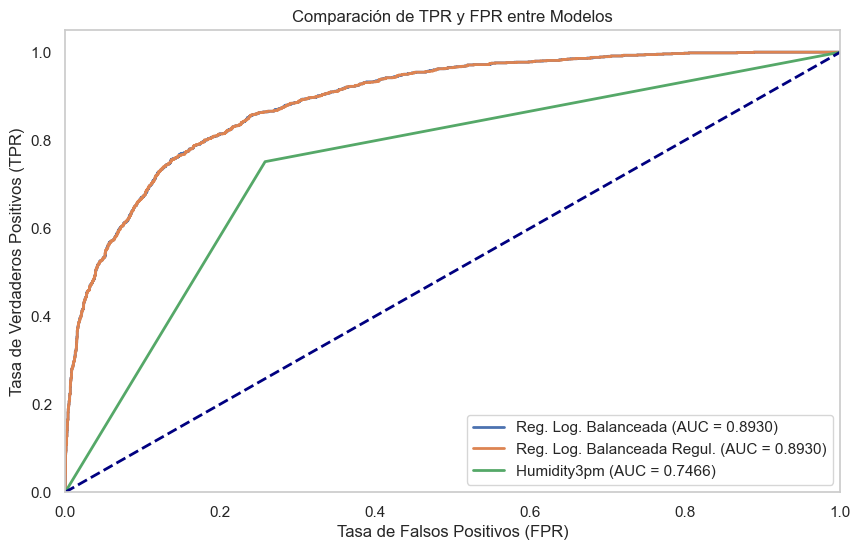

In [192]:
# Relación entre TPR/FPR de Curva ROC y AUC.

# Definir los modelos y sus TPR y FPR
model_names = ["Reg. Log. Balanceada", "Reg. Log. Balanceada Regul.", "Humidity3pm"]
tpr_values = [tpr_ba, tpr_re, tpr_hum]
fpr_values = [fpr_ba, fpr_re, fpr_hum]
y_probs_modelos = [y_probs_balanced, y_probs_reg, y_probs_humidity]  # Probabilidades de cada modelo

# Crear el gráfico
plt.figure(figsize=(10, 6))

for i, model in enumerate(model_names):
    # Calcular AUC para cada modelo
    auc_value = roc_auc_score(y_test_clean, y_probs_modelos[i])

    # Graficar TPR vs FPR
    plt.plot(fpr_values[i], tpr_values[i], lw=2, label=f'{model} (AUC = {auc_value:.4f})')

# Agregar líneas de referencia
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal

# Configurar el gráfico
plt.title("Comparación de TPR y FPR entre Modelos")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.grid()

# Mostrar el gráfico
plt.show()


Umbral óptimo: Calcular la distancia euclidiana de cada punto de la curva ROC a punto(0,1) o AUC=1.

Interesa la distancia mínima: qué tan "cerca" se encuentra de la esquina superior izquierda de la curva ROC, lo que indica un mejor equilibrio entre la tasa de verdaderos positivos y la tasa de falsos positivos.

$\text{distancia} = \sqrt{(\text{FPR})^2 + (1 - \text{TPR})^2}$

Objetivo: Ajustar umbrales para maximizar el pondered accuracy.

Pasos: 1) Obtener las Probabilidades de la Clase Positiva

       2) Curva ROC y los Umbrales : función roc_curve para calcular la TPR, FPR y los umbrales para cada modelo.

       3) Encontrar el Umbral Óptimo: 

       4) Hacer Predicciones Usando el Umbral Óptimo
       
       5) Evaluar el Rendimiento: Pondered Accuracy para cada modelo utilizando las predicciones ajustadas

NOTA: 

Cálculos ya realizados con antelación por modelo.:

**Predicciones de los distintos modelos:**
y_pred_balanced ,
y_pred_reg ,
y_pred_humidity

**1) Predicciones de Probabilidades**  

Probabilidades de las clases positivas para cada uno de los modelos (método predict_proba):

y_probs_balanced = logistic_model_balanced.predict_proba(x_test_clean)[:, 1]

y_probs_reg = logistic_model_balanced_regul.predict_proba(x_test_clean)[:, 1]

y_probs_humidity

**2) Curva ROC y los Umbrales ( thresholds) : función roc_curve para calcular la TPR, FPR y los umbrales.**

In [193]:
# # MARCE

# # Calcula Youden's J statistic para cada umbral
# J_scores = tpr_ba - fpr_ba
# optimal_idx = J_scores.argmax()
# optimal_threshold = thresholds_ba[optimal_idx]

# print("Umbral óptimo:", optimal_threshold)

Mejor umbral: 0.519433420266038
Distancia mínima al punto perfecto: 0.26932073026017395


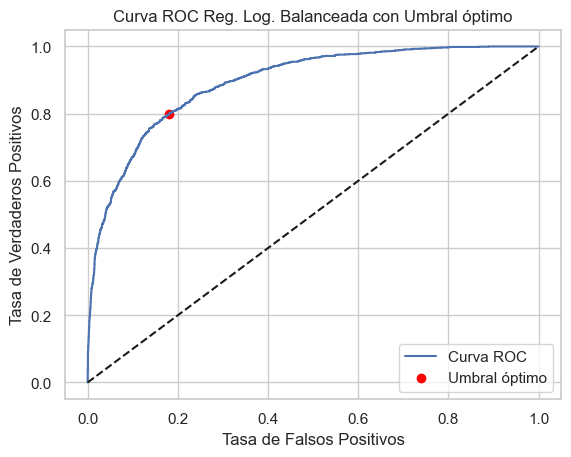

In [194]:
# Observamos Gráficamente Umbral Optimo unicamente para Reg. Logistica Balanceada (distancia a punto (0,1) --> donde AUC = 1)
"""Calcula la curva ROC con las etiquetas verdaderas y las probabilidades de clase positiva.
   Calcula la distancia euclidiana de cada punto de la curva al punto perfecto (0,1).
   Encuentra el umbral que minimiza esta distancia
"""

# Calcular la distancia al punto perfecto
distances = np.sqrt(fpr_ba**2 + (1 - tpr_ba)**2)

# Encontrar el índice del umbral que minimiza la distancia
min_distance_index = np.argmin(distances)
best_threshold = thresholds_ba[min_distance_index]
best_distance = distances[min_distance_index]

print("Mejor umbral:", best_threshold)
print("Distancia mínima al punto perfecto:", best_distance)

import matplotlib.pyplot as plt

plt.plot(fpr_ba, tpr_ba, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.scatter(fpr_ba[min_distance_index], tpr_ba[min_distance_index], color='red', label='Umbral óptimo')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Reg. Log. Balanceada con Umbral óptimo')
plt.legend()
plt.show()

In [195]:
# 3) Umbral Óptimo para modelo Balanceado, con Regularizacion y Base " Humidity3pm" y distancia mínima que los determina.
def find_optimal_threshold(fpr, tpr, thresholds):
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)  # Distancia
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]
    minimum_distance = distances[optimal_idx]
    return optimal_threshold, minimum_distance

# Encontrar umbrales óptimos
optimal_threshold_balanced, min_distance_balanced = find_optimal_threshold(fpr_ba, tpr_ba, thresholds_ba)
optimal_threshold_reg, min_distance_reg = find_optimal_threshold(fpr_re, tpr_re, thresholds_re)
optimal_threshold_hum, min_distance_hum = find_optimal_threshold(fpr_hum, tpr_hum, thresholds_hum)

# Imprimir resultados
print(f'Umbral óptimo (Reg. Log. Balanceada): {optimal_threshold_balanced:.2f}, Distancia mínima: {min_distance_balanced:.4f}')
print(f'Umbral óptimo (Reg. Log. Balanceada Regul.): {optimal_threshold_reg:.2f}, Distancia mínima: {min_distance_reg:.4f}')
print(f'Umbral óptimo (Humidity3pm): {optimal_threshold_hum:.2f}, Distancia mínima: {min_distance_hum:.4f}')


Umbral óptimo (Reg. Log. Balanceada): 0.52, Distancia mínima: 0.2693
Umbral óptimo (Reg. Log. Balanceada Regul.): 0.52, Distancia mínima: 0.2683
Umbral óptimo (Humidity3pm): 1.00, Distancia mínima: 0.3584


In [196]:
# 4) Predicciones finales usando los umbrales óptimos
y_pred_optimal_balanced = (y_probs_balanced >= optimal_threshold_balanced).astype(int)
y_pred_optimal_reg = (y_probs_reg >= optimal_threshold_reg).astype(int)
y_pred_optimal_hum = (y_probs_humidity >= optimal_threshold_hum).astype(int)

In [197]:
# ACA

# 5) Observación de rendimiento de modelos ajuste de umbral.

# Métricas modelo balanceado optimizado.
f1_balanced = f1_score(y_test_clean, y_pred_optimal_balanced)
balanced_acc_balanced = balanced_accuracy_score(y_test_clean, y_pred_optimal_balanced)
print(f'F1 Score (Reg. Log. Balanceada): {f1_balanced:.4f}, Balanced Accuracy: {balanced_acc_balanced:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_balanced))

# Métricas modelo balanceado y regularización 
f1_reg = f1_score(y_test_clean, y_pred_optimal_reg)
balanced_acc_reg = balanced_accuracy_score(y_test_clean, y_pred_optimal_reg)
print(f'F1 Score (Reg. Log. Balanceada Regul.): {f1_reg:.4f}, Balanced Accuracy: {balanced_acc_reg:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_reg))



F1 Score (Reg. Log. Balanceada): 0.6615, Balanced Accuracy: 0.8098
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4373
           1       0.56      0.80      0.66      1274

    accuracy                           0.82      5647
   macro avg       0.75      0.81      0.77      5647
weighted avg       0.85      0.82      0.83      5647

F1 Score (Reg. Log. Balanceada Regul.): 0.6626, Balanced Accuracy: 0.8106
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4373
           1       0.57      0.80      0.66      1274

    accuracy                           0.82      5647
   macro avg       0.75      0.81      0.77      5647
weighted avg       0.85      0.82      0.83      5647



In [198]:
# 5) Observación de rendimiento general de todas las métricas con ajuste de umbral (métricas con umbral óptimo)
metrics = {
    "Modelo": [
        "Regres. Log. Balanceada", 
        "Reg. Log. Balanc. Regularizada",  
        "Humidity3pm"
    ],
    "Accuracy": [
        accuracy_score(y_test_clean, y_pred_optimal_balanced),
        accuracy_score(y_test_clean, y_pred_optimal_reg),
        accuracy_score(y_test_clean, y_pred_optimal_hum)
    ],
    "Precision (Clase 0)": [
        precision_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        precision_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        precision_score(y_test_clean, y_pred_optimal_hum, pos_label=0)
    ],
    "Precision (Clase 1)": [
        precision_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        precision_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        precision_score(y_test_clean, y_pred_optimal_hum, pos_label=1)
    ],
    "Recall (Clase 0)": [
        recall_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        recall_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        recall_score(y_test_clean, y_pred_optimal_hum, pos_label=0)
    ],
    "Recall (Clase 1)": [
        recall_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        recall_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        recall_score(y_test_clean, y_pred_optimal_hum, pos_label=1)
    ],
    "F1 Score (Clase 0)": [
        f1_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        f1_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        f1_score(y_test_clean, y_pred_optimal_hum, pos_label=0)
    ],
    "F1 Score (Clase 1)": [
        f1_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        f1_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        f1_score(y_test_clean, y_pred_optimal_hum, pos_label=1)
    ],
    "Pondered Accuracy": [
        pondered_accuracy(y_test_clean, y_pred_optimal_balanced), 
        pondered_accuracy(y_test_clean, y_pred_optimal_reg), 
        pondered_accuracy(y_test_clean, y_pred_optimal_hum)
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


,Modelo,Accuracy,Precision (Clase 0),Precision (Clase 1),Recall (Clase 0),Recall (Clase 1),F1 Score (Clase 0),F1 Score (Clase 1),Pondered Accuracy
0,Regres. Log. Balanceada,0.815300,0.933594,0.563918,0.819803,0.799843,0.873006,0.661474,0.806496
1,Reg. Log. Balanc. Regularizada,0.816009,0.933889,0.565097,0.820489,0.800628,0.873524,0.662553,0.807248
2,Humidity3pm,0.744112,0.911005,0.458993,0.742054,0.751177,0.817895,0.569812,0.748136


### Métrica elegida -con ajuste de Umbral óptimo: Pondered Accuracy-

In [199]:
# ACA acomodor titulo Modelo

# Calcular las métricas para cada modelo con el umbral óptimo
metrics = {
    "Modelo": [ 
        "Regres. Log. Balanceada Regularizada Ridge", 
        "Reg. Log. Balanceada Regularizada Lasso", 
        "Humidity3pm"
    ],
    "Pondered Accuracy": [
        pondered_accuracy(y_test_clean, y_pred_optimal_balanced), 
        pondered_accuracy(y_test_clean, y_pred_optimal_reg), 
        pondered_accuracy(y_test_clean, y_pred_optimal_hum)
    ]
}

# Convertir a DataFrame
metrics_df_umbral = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df_umbral.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


,Modelo,Pondered Accuracy
0,Regres. Log. Balanceada Regularizada Ridge,0.806496
1,Reg. Log. Balanceada Regularizada Lasso,0.807248
2,Humidity3pm,0.748136


## Conclusión Final

ACA

En el contexto de los datos proporcionados, nos interesa maximizar el **Pondered Accuracy**, que implica maximizar los verdaderos positivos (TP) y minimizar los Falsos Negativos (error tipo 2).

 No obstante, vamos a observar el comportamiento general del modelo con la métrica **Balanced accuracy**, dado que esta métrica proporciona una evaluación equilibrada del rendimiento del modelo para ambas clases, lo que es crucial en situaciones de desbalance significativo. Nos interesa ver que no estemos sacrificando el rendimiento de la clase mayoritaria en post del incremento del rendimiento de la clase minoritaria.
  (Recordemos que la target que indica "si llueve" (Clase positiva: RainTomorrow = 1) es la minoritaria y "no llueve" (Clase negativa =0), donde "no llueve" es la clase mayoritaria.)

  Mediante la aplicacion de tecnicas de balanceo de datos conseguimos mejorar las metricas que consideramos mas importantes.


**Resultado**: El modelo con el cual se obtiene el mejor fitting general es el de Regresión Logística Balanceado y Regularizado.
Este modelo presenta un Pondered Accuracy de 0.807248.

Los modelos superan al modelo Base elegido "Humidity3pm".

## Punto 4: Optimización de selección de Hiperparámetros.

### Validación Cruzada - KFolds

Se evalúa con validación cruzada el modelo elegido, balanceado y con regularización L1, observando las métricas recall de clase 1 y balanced accuracy.

La validación cruzada es una técnica que se utiliza para evaluar la capacidad de generalización de un modelo de machine learning. Al separar el conjunto de validación dentro del conjunto de entrenamiento existe una fuga de datos que está aceptada.

Tres estrategias de validación cruzada:

1) KFold: Divide el conjunto de datos en n partes (o "folds"). En cada iteración, se entrena el modelo con (n-1) de esos folds y se valida con el fold restante. La opción shuffle=True asegura que los datos se barajen antes de dividirlos, y random_state=42 establece una semilla para la aleatoriedad, asegurando que los resultados sean reproducibles.

2) StratifiedKFold: Similar a KFold, pero intenta mantener la misma proporción de clases en cada fold. Esto es útil si tienes un conjunto de datos desbalanceado.

3) Leave-One-Out: Una forma extrema de validación cruzada donde para cada muestra en el conjunto de datos, el modelo se entrena con todas las muestras menos una, y se valida con esa única muestra. Esto se repite para cada muestra en el conjunto

Se elige la estrategia KFolds.

In [200]:
logistic_regressor = LogisticRegression(penalty='l1', C=1, solver='saga',random_state=42, class_weight= "balanced")
# Entrenar el modelo
logistic_regressor.fit(x_train_clean, y_train_clean)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(pondered_accuracy)
# Evaluar el modelo usando validación cruzada
scores_train = cross_val_score(logistic_regressor, x_train_clean, y_train_clean, cv=cv, scoring=scorer)

print(f"Puntuaciones de validación cruzada (pondered_accuracy): {scores_train}")
print(f"Media de las puntuaciones (pondered_accuracy): {scores_train.mean():.4f}")
print(f"Desvío Standart de las puntuaciones (pondered_accuracy): {scores_train.std():.4f}")

Puntuaciones de validación cruzada (pondered_accuracy): [0.80645157 0.81002557 0.7989144  0.81214384 0.80658117]
Media de las puntuaciones (pondered_accuracy): 0.8068
Desvío Standart de las puntuaciones (pondered_accuracy): 0.0045


In [201]:
# # Importo libreria para que muestres los resultados de la variables automaticamente en Markdown.
# from IPython.display import display, Markdown
# scores_train_mean= scores_train.mean()
# scores_train_std= scores_train.std()
# # Función para mostrar los resultados de K-Fold.
# def show_results_k_fold(scores_train_mean, scores_train_std):
#     display(Markdown(f"**balanced_accuracy- promedio**: **{scores_train_mean:.4f}**\n\n"))
#     display(Markdown(f"**balanced_accuracy- std**: **{scores_train_std:.4f}**\n\n"))

Rendimiento General: Una media alta indica que el modelo es eficaz para hacer predicciones.

Robustez: Un desvío estándar bajo indica que es menos probable que el modelo esté sesgado por los datos de entrenamiento y se vea afectado por la variabilidad en los datos. Se obtiene un modelo que generaliza bien en el conjunto de test.

No se utiliza validación cruzada  para la determinación de los hiperparámetros porque implica entrenar el modelo y probar en un conjunto de validación para cada combinación posible de hiperparámetros, para finalmente elegir los mejores y evaluar el comportamiento en el conjunto de testeo. Es muy costoso en tiempo y computacionalmente.

La búsqueda de los mejores hiperparámetros se realiza a través de las siguientes técnicas:

* Grid Search: GridSearchCV utiliza validación cruzada para encontrar la mejor combinación y mejorar el rendimiento, barriendo toda la grilla, es decir todas las combinaciones posibles de hiperparámentros. Este método es más costoso computacionalmente y da las mejores métricas.
* Random Search: RandomizedSearchCV validación cruzada para encontrar la mejor combinación y mejorar el rendimiento, eligiendo en forma aleatoria algunos puntos de la grilla, es decir, algunas combinaciones de hiperparámentros.
* Enfoque Bayesiano: el framework optuna hace una búsqueda secuencial de hiperparámetros que internamente usa el enfoque Bayesiano.

Con todas las técnicas se utiliza el solver 'saga', ya que es el único que ofrece compatibilidad con los tres tipos de regularización (l1, l2 y elasticnet).


Los hiperparámetros a optimizar son:

**C:** = 1/λ Hiperparámetro de regularización que controla la penalización de errores en la clasificación.
        Valores más altos de C pueden llevar a un modelo más complejo (menor regularización).
        Valores más bajos hacen que el modelo sea más simple (mayor regularización).

        Escala Logarítmica: Usar np.logspace(-5, 5, num=100) genera 100 valores entre 10(−5)  y 10(5) , lo que permite explorar un rango amplio de valores.

**penalty:** Tipo de penalización que se aplica al modelo.

        'l1': Regularización Lasso, que puede llevar a que algunos coeficientes sean cero.

        'l2': Regularización Ridge, que penaliza el tamaño de los coeficientes.

        'elasticnet': Combina ambos tipos de regularización

**max_iter**: Número máximo de iteraciones para el optimizador.
         Un número mayor de iteraciones permite que el modelo converja mejor, pero también incrementa el tiempo de computación.

        Rango: range(100, 1001) indica que se probarán valores entre 100 y 1000 (incluyendo 1000).


**class_weight**: Manejo del balance de clases, especialmente útil en conjuntos de datos desbalanceados.

        'balanced': Ajusta los pesos inversamente proporcionales a las frecuencias de las clases.

        None: No aplica pesos.

### Grid Search

Se realiza una prueba inicial con amplios rangos de valores para C y max_iter que se interrumpe después de 10 horas de ejecución.

C: 100 valores (np.logspace(-5, 5, num=100))

penalty: 4 opciones ('l1', 'l2', 'elasticnet', None)

max_iter: 901 valores (de range(100, 1001), que incluye 100 hasta 1000)

class_weight: 2 opciones ('balanced' y None)

Cantidad de iteraciones:

100×4×1×901×2=720800 combinaciones

y con GridSearchCV con validación cruzada con 5 divisiones

720800×5=3604000 iteraciones en total

Se opta por realizar una búsqueda amplia por lista de valores y en base a los resultados obtenidos ir ajustando los valores en las búsquedas siguientes para lograr mayor precisión en los resultados.

In [202]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['saga'],  # Necesario si se usa 'elasticnet' o 'l1' o 'l2'
    'max_iter': [10, 50, 100, 200, 500],
    'class_weight': ['balanced', None]
}

# 'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1'
# param_grid = {
#     'C': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50],
#     'penalty': ['l1'],
#     'solver': ['saga'],
#     'max_iter': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160],
#     'class_weight': ['balanced']
# }

# 'C': 8, 'max_iter': 70
# param_grid = {
#     'C': range(5, 10),
#     'penalty': ['l1'],
#     'solver': ['saga'],
#     'max_iter': range(60, 80),
#     'class_weight': ['balanced']
# }

# 'C': 8, 'max_iter': 65
# param_grid = {
#     'C':  [7.5, 7.6, 7.7, 7.8, 7.9, 8, 8.1, 8.2, 8.3, 8.4, 8.5],
#     'penalty': ['l1'],
#     'solver': ['saga'],
#     'max_iter': [65],
#     'class_weight': ['balanced']
# }

# param_grid = {
#     'C':  [8],
#     'penalty': ['l1'],
#     'solver': ['saga'],
#     'max_iter': [65],
#     'class_weight': ['balanced']
# }

# Usar make_scorer para personalizar el pondered_accuracy
scorer = make_scorer(pondered_accuracy)

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring=scorer,
    n_jobs=-1)
grid_search.fit(x_train_clean, y_train_clean)

# Obtener el mejor modelo y sus hiperparámetros
best_grid_params = grid_search.best_params_
best_grid_model = LogisticRegression(**best_grid_params, random_state=42)
best_grid_model.fit(x_train_clean, y_train_clean)

# Calcular las métricas en el conjunto de prueba
y_pred_grid = best_grid_model.predict(x_test_clean)
test_pondered_accuracy_grid = pondered_accuracy(y_test_clean, y_pred_grid)

print(f"Mejores parámetros del grid: {best_grid_params}")
print(f"Pondered accuracy en test: {test_pondered_accuracy_grid}")


Mejores parámetros del grid: {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Pondered accuracy en test: 0.8083445307972439


Se hace una aproximación inicial con listas de valores, dando los siguientes resultados:

Mejores parámetros del grid: {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Pondered accuracy en test: 0.8083445307972439

Mejores parámetros del grid: {'C': 8, 'class_weight': 'balanced', 'max_iter': 70, 'penalty': 'l1', 'solver': 'saga'}
Pondered accuracy en test: 0.8083445307972439


Luego se va ajustando la búsqueda por rango de valores en una zona delimitada y las mejores métricas se obtienen para la siguiente combinación de hiperparámetros:

Mejores parámetros del grid: {'C': 8, 'class_weight': 'balanced', 'max_iter': 65, 'penalty': 'l1', 'solver': 'saga'}
Pondered accuracy en test: 0.8083445307972439




### Random Search

Se entrenan 50 conjuntos de hiperparámetros (n_iter=50 )

Se prueban opciones de búsqueda por listas de valores específicos y por rango de valores para C y max-iter.

In [203]:
# param_random = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2', 'elasticnet', None],
#     'solver': ['saga'],  # Necesario si se usa 'elasticnet' o 'l1' o 'l2'
#     'max_iter': [10, 50, 100, 200, 500], #range(100, 1001), 
#     'class_weight': ['balanced', None]
# }

param_random = {
    'C': np.logspace(-5, 5, num=100),  # Valores de C en escala logarítmica
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['saga'],  # Necesario si se usa 'elasticnet' o 'l1' o 'l2'
    'max_iter': range(100, 1001),
    'class_weight': ['balanced', None]
}

# Usar make_scorer para personalizar el pondered_accuracy
scorer = make_scorer(pondered_accuracy)

random_search = RandomizedSearchCV(
    LogisticRegression(random_state=42),
    param_random,
    n_iter=50,
    cv=5,
    scoring=scorer,
    n_jobs=-1)
random_search.fit(x_train_clean, y_train_clean)

# Obtener el mejor modelo y sus hiperparámetros
best_random_params = random_search.best_params_
best_random_model = LogisticRegression(**best_random_params, random_state=42)
best_random_model.fit(x_train_clean, y_train_clean)

# Calcular las métricas en el conjunto de prueba
y_pred_random = best_grid_model.predict(x_test_clean)
test_pondered_accuracy_random = pondered_accuracy(y_test_clean, y_pred_random)

print(f"Mejores parámetros del random: {best_random_params}")
print(f"Pondered accuracy en test: {test_pondered_accuracy_random}")


Mejores parámetros del random: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 870, 'class_weight': 'balanced', 'C': np.float64(29.150530628251758)}
Pondered accuracy en test: 0.8083445307972439


Valores obtenidos en distintas ejecuciones:

Mejores parámetros del random: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 959, 'class_weight': 'balanced', 'C': 3.593813663804626}
Pondered accuracy en test: 0.8083445307972439

Mejores parámetros del random: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 751, 'class_weight': 'balanced', 'C': 36.783797718286344}
Pondered accuracy en test: 0.8083445307972439

Mejores parámetros del random: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 910, 'class_weight': 'balanced', 'C': 5.72236765935022}
Pondered accuracy en test: 0.8083445307972439


### Optuna

Se prueban dos opciones de búsqueda para C:
* C = trial.suggest_categorical('C', [0.01, 0.1, 1, 10, 100])
  Define C como una variable categórica. El optimizador sólo considerará los valores en la lista dada.
  Menos carga computacional, ya que se exploran solo valores discretos específicos. Es útil cuando se conocen los valores que suelen funcionar bien o se quiere reducir el tiempo de optimización.

* C = trial.suggest_float('C', 0.01, 100, log=True)
  Define C como una variable continua en el rango de 0.01 a 100. Al especificar log=True, se indica que C debe explorarse en una escala logarítmica. Esto permite que el optimizador explore valores en una escala amplia y encuentre cualquier valor entre 0.01 y 100. Se logra mayor precisión en la búsqueda.

Se prueban dos opciones de búsqueda para max_iter:
* max_iter = trial.suggest_categorical('max_iter', [100, 200, 500])
  Define max_iter como una variable categórica. El optimizador sólo considerará los valores en la lista dada.
* max_iter = trial.suggest_int('max_iter', 50, 1000)
  Define max_iter como una variable continua en el rango de 50 a 1000. Esto permite que el optimizador explore valores en una escala amplia y encuentre cualquier valor entre 50 y 1000.

In [204]:
# Dividir el conjunto de datos en entrenam iento y validación
x_train_op, x_val_op, y_train_op, y_val_op = train_test_split(x_train_clean, y_train_clean, test_size=0.2, random_state=42)

# Definir la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros que Optuna optimizará
    # C = trial.suggest_categorical('C', [0.01, 0.1, 1, 10, 100])
    C = trial.suggest_float('C', 0.01, 100, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    # max_iter = trial.suggest_categorical('max_iter', [10, 50, 100, 200, 500])
    max_iter = trial.suggest_int('max_iter', 50, 1000)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    solver = trial.suggest_categorical('solver', ['saga'])
    # Si se selecciona elasticnet, establecer l1_ratio; de lo contrario, l1_ratio es None
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None
    # Crear el modelo con los parámetros actuales
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        class_weight=class_weight,
        l1_ratio=l1_ratio,
        random_state=42,
        dual=False
    )
    # Entrenar el modelo y evaluar el pondered_accuracy
    model.fit(x_train_op, y_train_op)
    y_pred = model.predict(x_val_op)
    score = pondered_accuracy(y_val_op, y_pred)
    return score

# Crear el estudio de Optuna y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Obtener el mejor modelo y sus hiperparámetros
best_optuna_params = study.best_params
best_optuna_model = LogisticRegression(**best_optuna_params, random_state=42, dual=False)
best_optuna_model.fit(x_train_clean, y_train_clean)

# Calcular las métricas en el conjunto de prueba
y_pred_op = best_optuna_model.predict(x_test_clean)
test_pondered_accuracy_op = pondered_accuracy(y_test_clean, y_pred_op)

print(f"Mejores parámetros de Optuna: {best_optuna_params}")
print(f"Pondered accuracy en test: {test_pondered_accuracy_op}")

[I 2024-11-12 12:34:35,539] A new study created in memory with name: no-name-29223633-c953-4442-8533-f83b3ce3d8a7
[I 2024-11-12 12:34:36,235] Trial 0 finished with value: 0.8054119858186324 and parameters: {'C': 27.88801930029287, 'penalty': 'l1', 'max_iter': 308, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.8054119858186324.
[I 2024-11-12 12:34:36,973] Trial 1 finished with value: 0.6904850046749154 and parameters: {'C': 7.157094566100635, 'penalty': 'l1', 'max_iter': 337, 'class_weight': None, 'solver': 'saga'}. Best is trial 0 with value: 0.8054119858186324.
[I 2024-11-12 12:34:37,417] Trial 2 finished with value: 0.8047615793145674 and parameters: {'C': 0.11084920377873961, 'penalty': None, 'max_iter': 386, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.8054119858186324.
[I 2024-11-12 12:34:37,936] Trial 3 finished with value: 0.8056065762058672 and parameters: {'C': 1.5173609231013656, 'penalty': 'elasticnet', 'max_iter

Mejores parámetros de Optuna: {'C': 1.5173609231013656, 'penalty': 'elasticnet', 'max_iter': 937, 'class_weight': 'balanced', 'solver': 'saga', 'l1_ratio': 0.08316534626703553}
Pondered accuracy en test: 0.807897469881724


Valores obtenidos en distintas ejecuciones:
* Con trial.suggest_float('C', 0.01, 100, log=True)

Mejores parámetros de Optuna: {'C': 1.528818322320482, 'penalty': 'elasticnet', 'max_iter': 193, 'class_weight': 'balanced', 'solver': 'saga', 'l1_ratio': 0.6006340795642946}
Pondered accuracy en test: 0.8079736952037759

Mejores parámetros de Optuna: {'C': 1.448407939550456, 'penalty': 'l1', 'max_iter': 202, 'class_weight': 'balanced', 'solver': 'saga'}
Pondered accuracy en test: 0.8080499205258279

Mejores parámetros de Optuna: {'C': 1.0232774728392031, 'penalty': 'l1', 'max_iter': 663, 'class_weight': 'balanced', 'solver': 'saga'}
Pondered accuracy en test: 0.8079736952037759


### Optuna con validación cruzada

Se prueban dos opciones de búsqueda para C:
* C = trial.suggest_categorical('C', [0.01, 0.1, 1, 10, 100])
  Define C como una variable categórica. El optimizador sólo considerará los valores en la lista dada.
  Menos carga computacional, ya que se exploran solo valores discretos específicos. Es útil cuando se conocen los valores que suelen funcionar bien o se quiere reducir el tiempo de optimización.

* C = trial.suggest_float('C', 0.01, 100, log=True)
  Define C como una variable continua en el rango de 0.01 a 100. Al especificar log=True, se indica que C debe explorarse en una escala logarítmica. Esto permite que el optimizador explore valores en una escala amplia y encuentre cualquier valor entre 0.01 y 100. Se logra mayor precisión en la búsqueda.

Se prueban dos opciones de búsqueda para max_iter:
* max_iter = trial.suggest_categorical('max_iter', [100, 200, 500])
  Define max_iter como una variable categórica. El optimizador sólo considerará los valores en la lista dada.
* max_iter = trial.suggest_int('max_iter', 50, 1000)
  Define max_iter como una variable continua en el rango de 50 a 1000. Esto permite que el optimizador explore valores en una escala amplia y encuentre cualquier valor entre 50 y 1000.

In [205]:
# Definir la función objetivo para Optuna con validación cruzada k-folds
def objective(trial):
    # Definir los hiperparámetros que Optuna optimizará
    # C = trial.suggest_categorical('C', [0.01, 0.1, 1, 10, 100])
    C = trial.suggest_float('C', 0.01, 100, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    # max_iter = trial.suggest_categorical('max_iter', [100, 200, 500])
    max_iter = trial.suggest_int('max_iter', 50, 1000)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    solver = trial.suggest_categorical('solver', ['saga'])
    # Si se selecciona elasticnet, establecer l1_ratio; de lo contrario, l1_ratio es None
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None
    # Crear el modelo con los parámetros actuales
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        class_weight=class_weight,
        l1_ratio=l1_ratio,
        random_state=42,
        dual=False
    )
    # Definir el método de validación cruzada y la métrica de evaluación
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(pondered_accuracy)
    # Usar cross_val_score para calcular el pondered_accuracy promedio en k-folds
    scores = cross_val_score(model, x_train_clean, y_train_clean, cv=skf, scoring=scorer)
    mean_score = scores.mean()
    # Devolver el pondered_accuracy promedio
    return mean_score

# Crear el estudio de Optuna y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Obtener el mejor modelo y sus hiperparámetros
best_optuna_params_kfolds = study.best_params
best_optuna_model_kfolds = LogisticRegression(**best_optuna_params_kfolds, random_state=42, dual=False)
best_optuna_model_kfolds.fit(x_train_clean, y_train_clean)

# Calcular las métricas en el conjunto de prueba
y_pred_op_kfolds = best_optuna_model_kfolds.predict(x_test_clean)
test_pondered_accuracy_op_kfolds = pondered_accuracy(y_test_clean, y_pred_op_kfolds)

# Imprimir las métricas
print(f"Mejores parámetros de Optuna: {best_optuna_params_kfolds}")
print(f"Balanced Accuracy en test: {test_pondered_accuracy_op_kfolds:.4f}")

[I 2024-11-12 12:34:53,316] A new study created in memory with name: no-name-3a51ed6f-4120-4e93-85e4-ab3dd8378218
[I 2024-11-12 12:35:04,618] Trial 0 finished with value: 0.6906117760658925 and parameters: {'C': 0.5746103942811113, 'penalty': 'elasticnet', 'max_iter': 748, 'class_weight': None, 'solver': 'saga', 'l1_ratio': 0.13013143761239976}. Best is trial 0 with value: 0.6906117760658925.
[I 2024-11-12 12:35:12,057] Trial 1 finished with value: 0.8061910985751087 and parameters: {'C': 30.7714317669612, 'penalty': 'l1', 'max_iter': 330, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 1 with value: 0.8061910985751087.
[I 2024-11-12 12:35:13,485] Trial 2 finished with value: 0.8025867014146011 and parameters: {'C': 0.013687750775242275, 'penalty': 'elasticnet', 'max_iter': 394, 'class_weight': 'balanced', 'solver': 'saga', 'l1_ratio': 0.9556970852642847}. Best is trial 1 with value: 0.8061910985751087.
[I 2024-11-12 12:35:17,674] Trial 3 finished with value: 0.69081977876

Mejores parámetros de Optuna: {'C': 30.7714317669612, 'penalty': 'l1', 'max_iter': 330, 'class_weight': 'balanced', 'solver': 'saga'}
Balanced Accuracy en test: 0.8083


Valores obtenidos en distintas ejecuciones:

Mejores parámetros de Optuna: {'C': 9.75470802546965, 'penalty': None, 'max_iter': 321, 'class_weight': 'balanced', 'solver': 'saga'}
Balanced Accuracy en test: 0.8083

Mejores parámetros de Optuna: {'C': 53.58858883361406, 'penalty': 'l1', 'max_iter': 137, 'class_weight': 'balanced', 'solver': 'saga'}
Balanced Accuracy en test: 0.8083

Mejores parámetros de Optuna: {'C': 32.32890354646821, 'penalty': 'l1', 'max_iter': 208, 'class_weight': 'balanced', 'solver': 'saga'}
Balanced Accuracy en test: 0.8083

### Comparación de métodos

In [206]:
best_grid_params

{'C': 10,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'}

In [207]:
best_random_params

{'solver': 'saga',
 'penalty': 'l1',
 'max_iter': 870,
 'class_weight': 'balanced',
 'C': np.float64(29.150530628251758)}

In [208]:
best_optuna_params

{'C': 1.5173609231013656,
 'penalty': 'elasticnet',
 'max_iter': 937,
 'class_weight': 'balanced',
 'solver': 'saga',
 'l1_ratio': 0.08316534626703553}

In [209]:
best_optuna_params_kfolds

{'C': 30.7714317669612,
 'penalty': 'l1',
 'max_iter': 330,
 'class_weight': 'balanced',
 'solver': 'saga'}

In [210]:
print("Grid Search Pondered Accuracy:", test_pondered_accuracy_grid)
print("Random Search Pondered Accuracy:", test_pondered_accuracy_random)
print("Optuna Pondered Accuracy:", test_pondered_accuracy_op)
print("Optuna K-Folds Pondered Accuracy:", test_pondered_accuracy_op_kfolds)

Grid Search Pondered Accuracy: 0.8083445307972439
Random Search Pondered Accuracy: 0.8083445307972439
Optuna Pondered Accuracy: 0.807897469881724
Optuna K-Folds Pondered Accuracy: 0.8083445307972439


ACA

Si bien las mejores métricas son las de la prueba Optuna, no son valores confiables por tratarse de una única prueba con  conjunto de validación pero sin validación cruzada.

Los hiperparámetros elegidos son:....

## Punto 5: Explicabilidad -SHARP-

In [211]:
# Construyo el modelo que reporta la mejor métrica 
model = LogisticRegression(C= 1, class_weight= 'balanced', max_iter= 10, penalty= 'l2', solver= 'lbfgs',random_state=42)
model.fit(x_train_clean,y_train_clean)
y_pred = model.predict(x_test_clean)

In [212]:
# Cambio el tipo de dato a array para evitar problemas con los métodos de sharp
array_x_train_clean = np.array(x_train_clean)
array_x_test_clean = np.array(x_test_clean)
features = x_train_clean.columns

In [213]:
# Crea un objeto explainer SHAP y observo el valor esperado
explainer = shap.LinearExplainer(model,array_x_train_clean , feature_names = features)
explainer.expected_value

np.float64(-1.0596446915911866)

El logaritmo de las chances promedio es, aproximadamente, 1.06 NEGATIVO, lo cual indica que el modelo predice que la mayoría de las muestran pertenecen a la clase 0, es decir, hay más muestras sobre las cuales se predice que al día siguiente no va a llover que muestras sobre las cuales el modelo predice lo contrario. 

In [214]:
# Calcula los valores SHAP para un conjunto de ejemplos de test
shap_values = explainer.shap_values(array_x_test_clean)

### Interpretabilidad **local**
Interesa analizar la explicabilidad de una muestra para la cual la predicción de probabilidad de que pertenezca a la clase 1 sea la máxima observada

In [215]:
y_pred = model.predict_proba(array_x_test_clean)
idx_max_proba_clase_1 = y_pred[:,1].argmax()
y_pred[idx_max_proba_clase_1]

array([6.70871847e-04, 9.99329128e-01])

Nuestro modelo predice para esta muestra una probabilidad de pertenencia a la clase 1 de 0.9993

In [216]:
model.predict(array_x_test_clean)[idx_max_proba_clase_1]

np.int64(1)

In [217]:
shap_value_obs_max_proba_clase_1 = shap_values[idx_max_proba_clase_1]
peso_features = pd.Series(shap_value_obs_max_proba_clase_1,index=x_train_clean.columns).sort_values(ascending=False)

In [218]:
# Se analiza cuáles son las features que explicarían por qué el logaritmo de las chances de esta obs es mayor al valor base  
peso_features[peso_features>0]

WindGustSpeed    3.132373
Humidity3pm      2.166676
Sunshine         1.004048
Cloud3pm         0.658964
Humidity9am      0.387969
WindSpeed3pm     0.318050
Temp3pm          0.164296
Pressure3pm      0.137479
Evaporation      0.106592
Longitude        0.076786
WindDir3pm_S     0.076277
WindDir9am_N     0.069964
MinTemp          0.049695
WindGustDir_S    0.040981
MaxTemp          0.038679
WindDir3pm_N     0.038514
WindDir9am_S     0.028364
Month_mar        0.016921
Month_ene        0.016366
WindDir9am_W     0.011330
WindDir3pm_W     0.009019
Month_nov        0.006325
Cloud9am         0.005088
Month_sep        0.003873
Month_jun        0.003591
Month_feb        0.003510
Month_dic        0.003001
Month_oct        0.002598
dtype: float64

In [219]:
# Se analiza cuáles son las features que explicarían por qué el logaritmo de las chances de esta obs es menor al valor base
peso_features[peso_features<0]

WindGustDir_N   -0.000689
Latitude        -0.003609
Month_ago       -0.006356
Pressure9am     -0.012335
WindGustDir_W   -0.012776
Month_may       -0.014172
Month_jul       -0.023923
WindSpeed9am    -0.025191
Rainfall        -0.030487
RainToday_Yes   -0.030494
Temp9am         -0.051393
dtype: float64

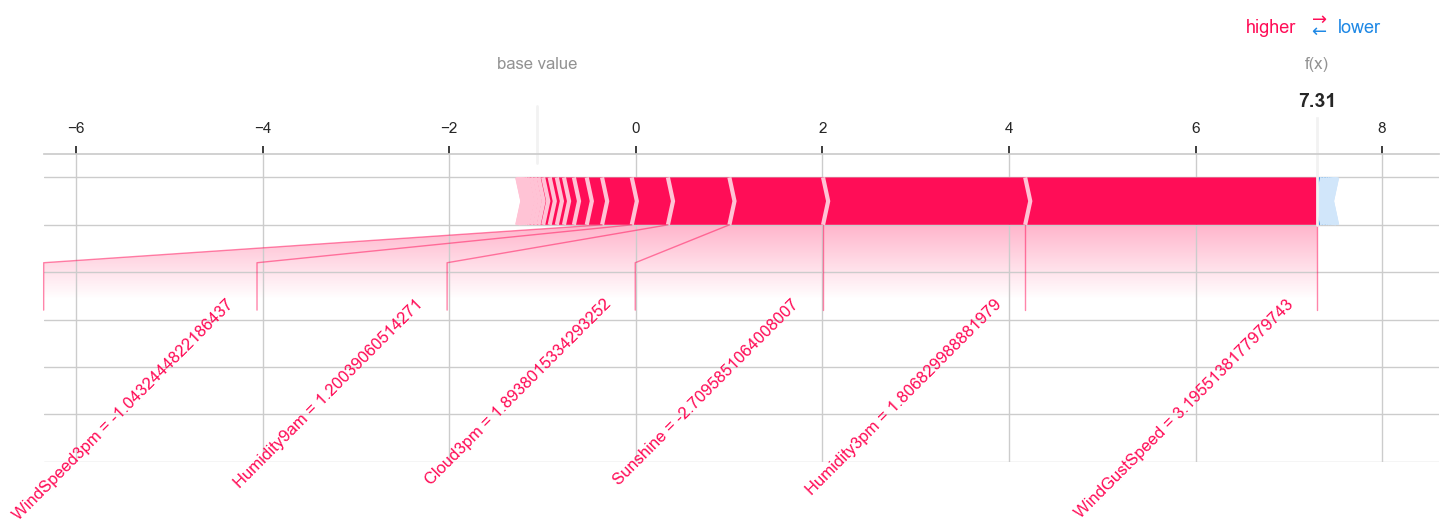

In [124]:
shap.force_plot(explainer.expected_value, shap_values[idx_max_proba_clase_1],
                array_x_test_clean[idx_max_proba_clase_1], feature_names=features,
                matplotlib=True, figsize=(18, 4), text_rotation=45)

El logaritmo de las chances para esta observación es de 7.31, bien alejado del valor base esperado de, aproximadamente, -1.06, entre las features que realizan el mayor aporte para explicar por qué la predicción de probabilidad de lluvia al día siguiente es significativamente elevada se encuentran: la velocidad de las ráfagas de viento (alta), la humedad de las 3 p.m (alta), la luminosidad (baja), entre las principales. Sin embargo, no todas las features se comportan de esta manera, pues se observan que 11 features que adoptan valores que contrarestan este efecto, la más importante operando en el sentido contrario es la temperatura de las 9 a.m 

In [220]:
explanation = shap.Explanation(values=shap_values[idx_max_proba_clase_1],
                               base_values=explainer.expected_value,
                               feature_names=features)

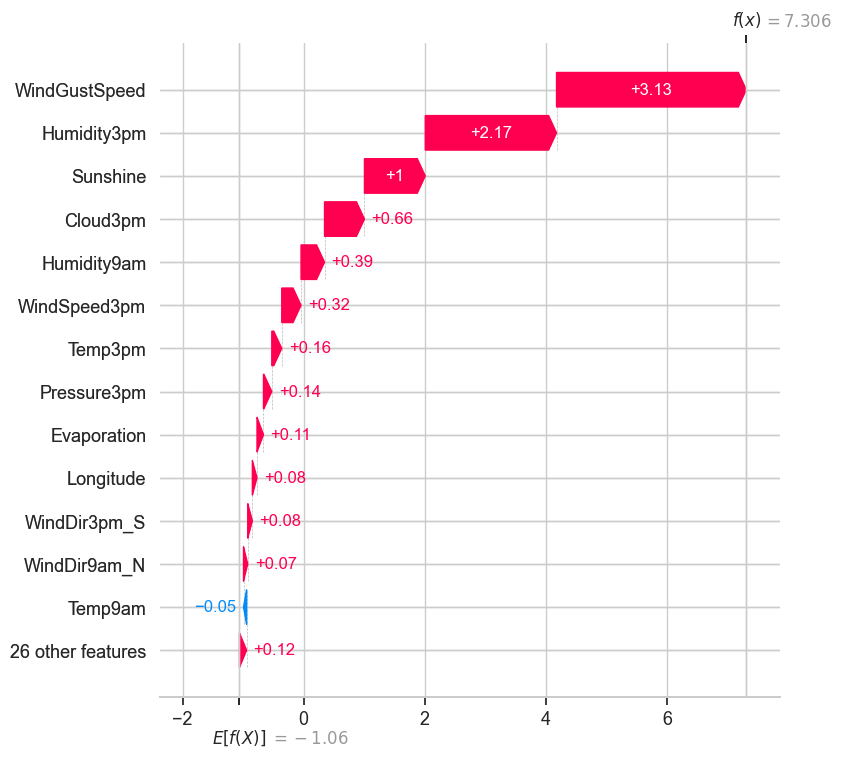

In [221]:
shap.plots.waterfall(explanation,max_display=14)

La velocidad de las ráfagas de viento de esta observación motiva a que su logaritmo de las chances aumente 3.13 con respecto al logaritmo de las chances esperado. Por el contario, la temperatura de las 9 am tiene el efecto de bajar 0.05 el logaritmo de las chaces de esta observación con respecto al valor esperado. 

### Interpretabilidad **global**

In [278]:
explanation = shap.Explanation(
    values=shap_values, 
    base_values=explainer.expected_value,
    feature_names=features,
    data=array_x_test_clean
)

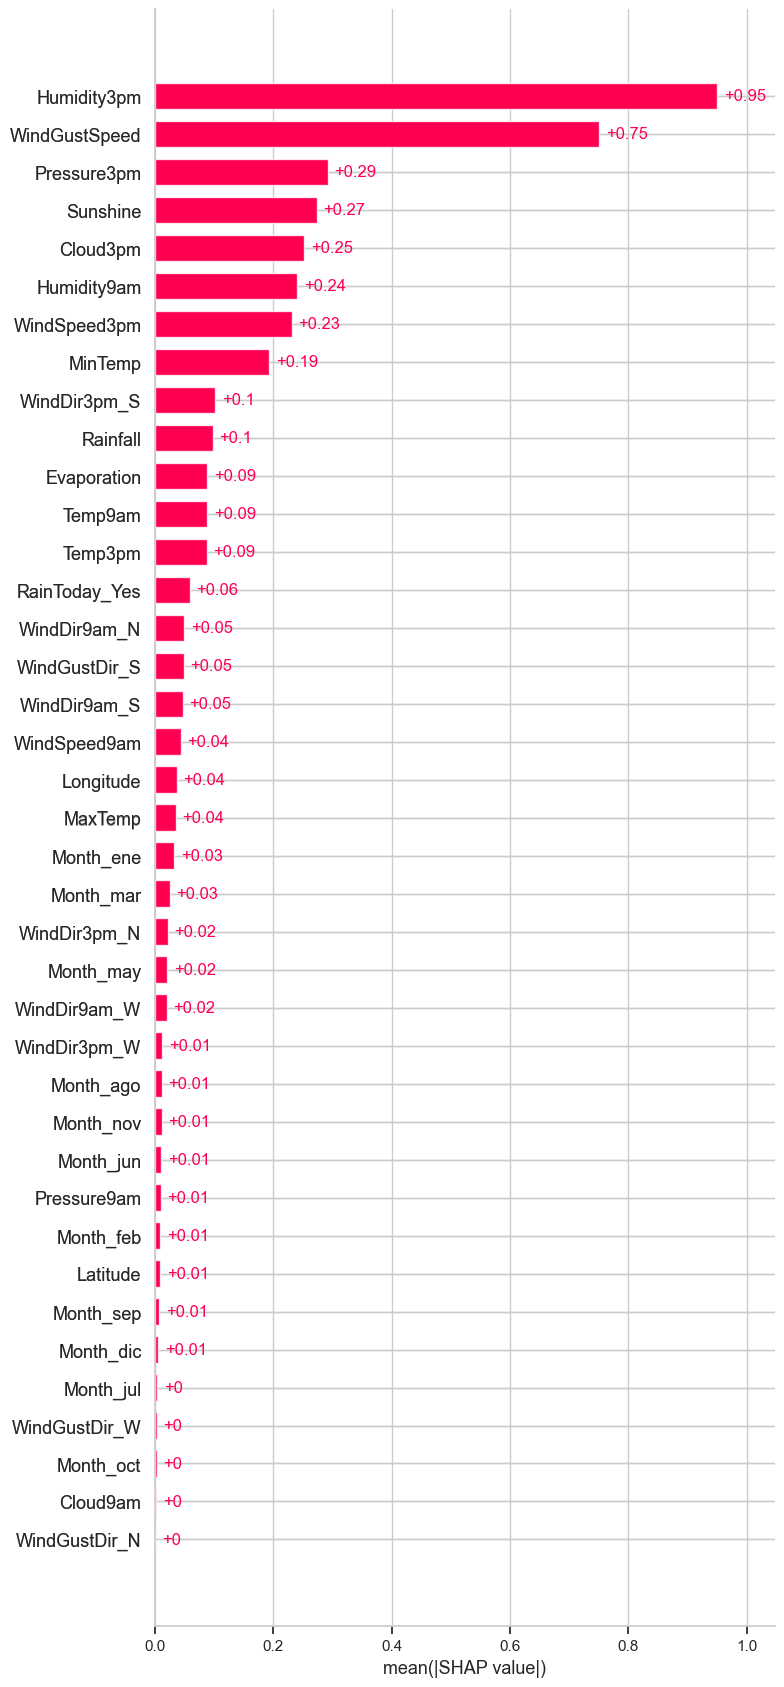

In [ ]:
# Este gráfico es de difícil interpretación porque la explicabilidad de ciertas features cualitativas 
# está desagrupada en varias columnas dummies, por ende, se jusitifica realizar una reagrupación.
shap.plots.bar(explanation,max_display=len(features))

In [280]:
shap_values_abs = np.abs(shap_values)
shap_values_abs_mean_by_feature = np.mean(shap_values_abs,axis=0)
explicabilidad_s = pd.Series(shap_values_abs_mean_by_feature,index=features)
explicabilidad_s = round(explicabilidad_s.sort_values(ascending=False),2)
explicabilidad_s

Humidity3pm      0.95
WindGustSpeed    0.75
Pressure3pm      0.29
Sunshine         0.27
Cloud3pm         0.25
Humidity9am      0.24
WindSpeed3pm     0.23
MinTemp          0.19
WindDir3pm_S     0.10
Rainfall         0.10
Evaporation      0.09
Temp9am          0.09
Temp3pm          0.09
RainToday_Yes    0.06
WindDir9am_N     0.05
WindGustDir_S    0.05
WindDir9am_S     0.05
WindSpeed9am     0.04
Longitude        0.04
MaxTemp          0.04
Month_ene        0.03
Month_mar        0.03
WindDir3pm_N     0.02
Month_may        0.02
WindDir9am_W     0.02
WindDir3pm_W     0.01
Month_ago        0.01
Month_nov        0.01
Month_jun        0.01
Pressure9am      0.01
Month_feb        0.01
Latitude         0.01
Month_sep        0.01
Month_dic        0.01
Month_jul        0.00
WindGustDir_W    0.00
Month_oct        0.00
Cloud9am         0.00
WindGustDir_N    0.00
dtype: float64

In [281]:
def reasignacion(exp_features_con_dummies:pd.Series)->pd.Series:
    dict_map = {
        'Location' : [ 'Latitude','Longitude',],
        'Date' : [ 'Month_ago','Month_dic','Month_ene','Month_feb','Month_jul','Month_jun','Month_mar','Month_may','Month_nov','Month_oct','Month_sep'],
        'WindGustDir' : [ 'WindGustDir_N','WindGustDir_S','WindGustDir_W',],
        'WindDir9am' : [  'WindDir9am_N','WindDir9am_S','WindDir9am_W'],
        'WindDir3pm' : [ 'WindDir3pm_N','WindDir3pm_S','WindDir3pm_W',],
    }
    dummy_features = []
    for dummy_cols in dict_map.values():
        dummy_features += dummy_cols
    exp_features_sin_dummies = pd.Series() 
    for feature,shap_mean_abs_value in exp_features_con_dummies.items():
        if feature not in dummy_features:
            exp_features_sin_dummies[feature] = shap_mean_abs_value
    for feature_cuantitativa,dummies in dict_map.items():
        shap_mean_abs_value_acumulado = 0
        for dummy in dummies:
            shap_mean_abs_value_acumulado += exp_features_con_dummies[dummy]
        exp_features_sin_dummies[feature_cuantitativa] = shap_mean_abs_value_acumulado
    return exp_features_sin_dummies
explicabilidad_reasignada= reasignacion(explicabilidad_s)    
explicabilidad_reasignada = explicabilidad_reasignada.sort_values(ascending=False)

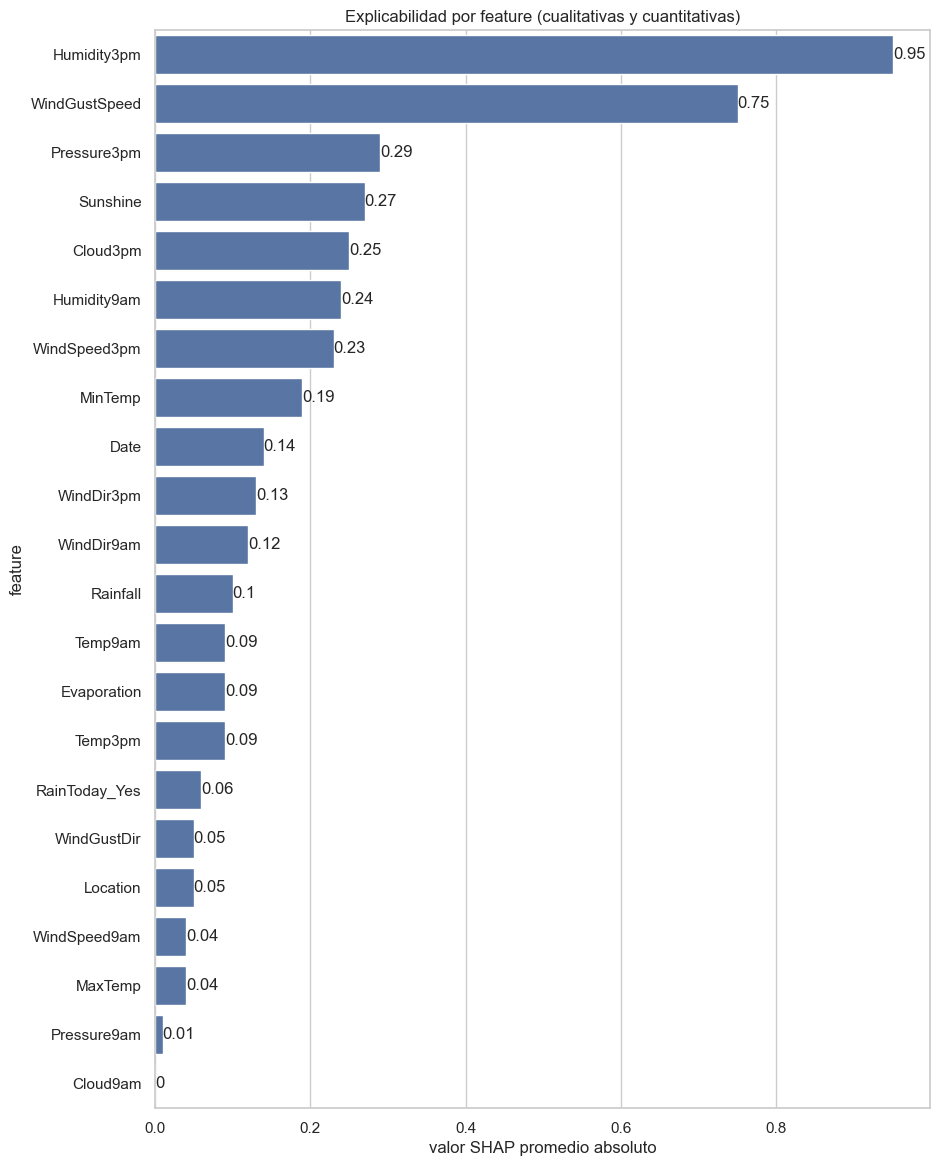

In [282]:
plt.figure(figsize=(10,14))
ax = sns.barplot(x=explicabilidad_reasignada.values,y=explicabilidad_reasignada.index)
plt.title('Explicabilidad por feature (cualitativas y cuantitativas)')
plt.ylabel('feature')
plt.xlabel('valor SHAP promedio absoluto')
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

En base al valor SHAP promedio en valor absoluto de las features puede inferirse cuáles son las más importantes para predecir la probabilidad de que al día siguiente llueva, por lo cual, resulta factible afirmar que, en promedio, la humedad de las 3 pm, la velocidad de las ráfagas de viento y la presión de las 3 pm, en este orden, son las variables explicativas más importantes para predecir el valor de la target. Por el contrario, la nubosidad de las 9 am no es una variable relevante según el modelo para predecir si al día siguiente va a llover, motivo por el cual esta feature podría ser descartada del modelo. Como así también la temperatura máxima y la presión de las 9 a.m

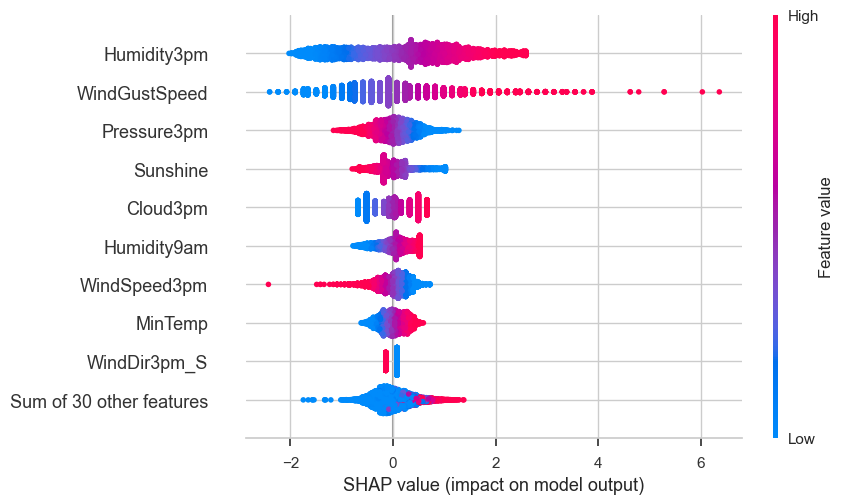

In [129]:
shap.plots.beeswarm(explanation)

Se observa una correlación positiva entre la humedad de las 3 pm y la probabilidad de que llueva al día siguiente, a mayores valores de humedad, mayores SHAP values (aumento del logaritmo de las chances). Por el contrario, la presión de las 3 pm muestra una correlación negativa con la target. En relación a la velocidad de las ráfagas de viento, se disntingue una gran dispersión que no obstante incluye valores SHAP atípicos. En relación a la humedad de las 9 am, se observa una distribución bimodal. 

## Punto 6 : Implementar Modelo de AUTO-ML con scikit-learn

In [130]:
# %pip install auto-sklearn

In [131]:
# import autosklearn.classification
# cls = autosklearn.classification.AutoSklearnClassifier()
# cls.fit(x_train_clean, y_train_clean)
# predictions = cls.predict(x_test_clean)


## Punto 6 : Implementar Modelo de AUTO-ML con Pycaret

In [156]:
#Función para calculo de métrica Pondered_accuracy
def pondered_accuracy(y_true, y_pred, **kwargs):  # **kwargs, para que se pasen a la función cualquier cantidad de argumentos adicionales en forma de pares clave-valor.
    y_true = np.array(y_true)    # Verificar que los valores sean arrays de numpy para evitar problemas de comparación
    y_pred = np.array(y_pred)
    recall_scorer_0 = recall_score(y_true, y_pred, pos_label=0)
    recall_scorer_1 = recall_score(y_true, y_pred, pos_label=1)
    return (2 * recall_scorer_1 + recall_scorer_0)/3

In [157]:
# Concatenar Datasets de Train y test completos
train_data_py = pd.concat([x_train_clean, y_train_clean], axis=1)
test_data_py = pd.concat([x_test_clean, y_test_clean], axis=1)

# Restablecer el índice para evitar duplicados
train_data_py = train_data_py.reset_index(drop=True)
test_data_py = test_data_py.reset_index(drop=True)

In [158]:
# Ejecutar setup() para preparar el entorno de PyCaret.
clf_py = setup(data=train_data_py, target='RainTomorrow_Yes', session_id=123, test_data=test_data_py, index=False, fix_imbalance=True)

,Description,Value
0,Session id,123
1,Target,RainTomorrow_Yes
2,Target type,Binary
3,Original data shape,"(27900, 40)"
4,Transformed data shape,"(40131, 40)"
5,Transformed train set shape,"(34484, 40)"
6,Transformed test set shape,"(5647, 40)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


In [159]:
# Definimos metrica personalizada con la funcion pondered_accuracy
add_metric('pondered_accuracy_metric', 'Pondered Accuracy Metric', pondered_accuracy, greater_is_better=True)

Name                                          Pondered Accuracy Metric
Display Name                                  Pondered Accuracy Metric
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(pondered_accuracy, response_method...
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: pondered_accuracy_metric, dtype: object

In [160]:
# Usamos compare_models() para realizar la comparación de modelos y obtener un DataFrame con los resultados.
best_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:28:14
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Pondered Accuracy Metric,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8651,0.9083,0.6635,0.7167,0.6890,0.6031,0.6039,0.7503,0.7720
et,Extra Trees Classifier,0.8576,0.9018,0.6402,0.7014,0.6693,0.5788,0.5798,0.7337,1.5710
rf,Random Forest Classifier,0.8567,0.9031,0.6863,0.6804,0.6832,0.5906,0.5907,0.7596,2.3040
gbc,Gradient Boosting Classifier,0.8437,0.8987,0.7280,0.6331,0.6771,0.5746,0.5772,0.7778,4.4170
ada,Ada Boost Classifier,0.8218,0.8836,0.7466,0.5813,0.6536,0.5361,0.5438,0.7789,1.0450
ridge,Ridge Classifier,0.8091,0.8919,0.8038,0.5525,0.6548,0.5292,0.5469,0.8061,0.0970
lda,Linear Discriminant Analysis,0.8091,0.8919,0.8038,0.5525,0.6548,0.5292,0.5469,0.8061,0.1160
lr,Logistic Regression,0.8083,0.8924,0.8026,0.5511,0.6535,0.5272,0.5450,0.8050,0.6930
svm,SVM - Linear Kernel,0.8013,0.8872,0.7968,0.5412,0.6439,0.5133,0.5324,0.7988,0.1980
dt,Decision Tree Classifier,0.7940,0.7309,0.6160,0.5376,0.5740,0.4391,0.4409,0.6926,0.3620


In [161]:
best_model


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

Se obtiene como mejor modelo: LGBMCClassifier
* LGBMClassifier (LightGBM): LightGBM es una implementación optimizada de "GBDT" (boosting "Gradient Boosting Decision Tree", método iterativo que construye árboles secuenciales, optimizando el error residual de cada etapa)
* LGBMClassifier aplica la misma idea de GBDT (boosting con árboles de decisión) pero con optimizaciones específicas para mejorar velocidad y eficiencia en grandes conjuntos de datos.
* GBDT (Gradient Boosting Decision Trees): Es una técnica de boosting que combina múltiples árboles de decisión secuenciales, donde cada árbol intenta corregir los errores del anterior. Al sumar estos árboles, el modelo final es una combinación de los predictores.

In [ ]:
# Verifica los gráficos disponibles para el modelo actual
available_plots = get_config('_available_plots')
print(available_plots)

{'pipeline': 'Pipeline Plot', 'parameter': 'Hyperparameters', 'auc': 'AUC', 'confusion_matrix': 'Confusion Matrix', 'threshold': 'Threshold', 'pr': 'Precision Recall', 'error': 'Prediction Error', 'class_report': 'Class Report', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'calibration': 'Calibration Curve', 'vc': 'Validation Curve', 'dimension': 'Dimensions', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'boundary': 'Decision Boundary', 'lift': 'Lift Chart', 'gain': 'Gain Chart', 'tree': 'Decision Tree', 'ks': 'KS Statistic Plot'}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

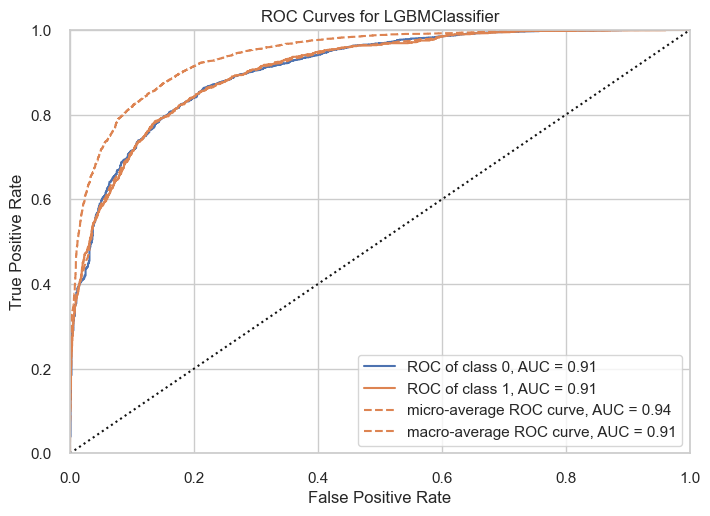

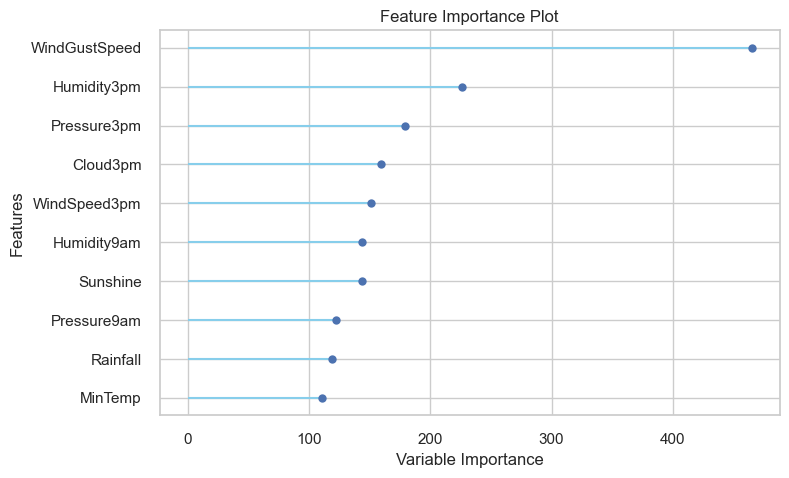

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Pondered Accuracy Metric
0,Light Gradient Boosting Machine,0.8606,0.9058,0.6562,0.7055,0.6800,0.5910,0.5917,0.7442


       MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     0.718165  1.262832 -0.322107     1.211113  1.007699       0.833085   
1     0.843394  0.139664  0.554187     0.238936  0.320968      -1.529343   
2     1.375616  0.398857  1.292119     0.416342 -2.365392       1.592437   
3    -1.238535 -0.335522 -0.414349    -0.199126 -0.002231      -0.769991   
4    -0.753273  1.205233 -0.414349    -0.378428  0.147216      -0.095011   
...        ...       ...       ...          ...       ...            ...   
5642 -0.205397  1.147635 -0.414349     1.211113  1.248634      -0.601246   
5643 -0.972424  0.643650 -0.414349     0.787235  1.179795      -0.263756   
5644 -0.252358 -0.277924 -0.414349    -0.537382  0.388151       0.073733   
5645  1.313001  2.486796 -0.414349    -0.669885 -0.464016      -0.769991   
5646 -0.518469 -1.228296 -0.414349    -0.582480 -0.153470       3.448631   

      WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  Month_jul  \
0        

In [ ]:
# Evaluar el mejor modelo con otras métricas disponibles en evaluate_model.
evaluate_model(best_model)

# Verificar si el modelo best_model es de clasificación, antes de intentar generar una curva ROC, asegurándose de que el modelo sea compatible con esta evaluación
if 'Classifier' in str(type(best_model)):      # verifica si best_model es un clasificador, revisando si el tipo de modelo contiene la palabra "Classifier". Si es de clasificación, genera la curva ROC
    # Generar la curva ROC solo si el modelo es un clasificador
    plot_model(best_model, plot='auc')
else:
    print("El modelo no es de clasificación. No se puede generar la curva ROC.")

# Mostrar la importancia de las características
plot_model(best_model, plot='feature')

# Guardar el modelo para usarlo en producción
save_model(best_model, 'best_model_AUTOML')

# Cargar el modelo guardado, para verificar su funcionamiento.
loaded_model = load_model('best_model_AUTOML')

# Hacer predicciones en el conjunto de test con el modelo cargado
predictions = predict_model(loaded_model, data=test_data_py)
print(predictions)

Conclusión AUTOML PYCARET vs Reg. Log.

El modelo que AUTOML PyCaret determina como mejor modelo para los datos brindados, es un clasificador LGBMClassifier, ya que es el que mejor métricas tiene en general, no obstante, evaluando la métrica Pondered Accuracy Metric (media ponderada del recall de ambas clases - lluvia y no lluvia), dicho modelo presenta un rendimiento inferior ( 0.7503) al modelo de regresión logística obtenido con GridSearch (Pondered accuracy en test: 0.8101).

La importancia de las características es diferente entre el modelo de AUTOML PyCaret (LGBMClassifier) y la regresión logística. Si bien las 3 caract. principales son iguales, cambia el orden de importancia , siendo WindGustSpeed (velocidad de las ráfagas de viento) para LGBMClassifier la característica que más aporta a la predicción, seguida de la humedad de las 3 pm y la presión de las 3 pm. 

**Reg Log con AutoMl vs Reg Log con optimizacion de Hiperparámetros:**

Si analizamos la métrica Pondered_acuracy obtenida en Logistic Regression de AutoMl con Pycaret (0.8050) en relacion a la métrica obtenida con Optimización de hiperparámetros de nuestro modelo (0.8101), notamos que también es más robusto este uúiltimo modelo.  